In [1]:
%run SAT_help_functions.ipynb

##  0.9 quantile

In [2]:
def get_RT_quantile_sub(df, correct, corrects, cond, conds, rt, quantiles = [.1, .3, .5, .7, .9]):
    
    # RT quantiles
    #print(df)
    #print(correct)
    #print(corrects[0])
    df_cor = df.loc[df[correct]==corrects[0]]
    RT_cor_s = df_cor.loc[df_cor[cond]==conds[0]][rt].quantile(q=quantiles)
    RT_cor_a = df_cor.loc[df_cor[cond]==conds[1]][rt].quantile(q=quantiles)
    
    df_err = df.loc[df[correct]==corrects[1]]
    RT_err_s = df_err.loc[df_err[cond]==conds[0]][rt].quantile(q=quantiles)
    RT_err_a = df_err.loc[df_err[cond]==conds[1]][rt].quantile(q=quantiles)
    
    # number of trials
    num_cor_s = len(df_cor.loc[df_cor[cond]==conds[0]])
    num_cor_a = len(df_cor.loc[df_cor[cond]==conds[1]])

    num_err_s = len(df_err.loc[df_err[cond]==conds[0]])
    num_err_a = len(df_err.loc[df_err[cond]==conds[1]])
    
    return RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, [num_cor_s,num_cor_a,num_err_s,num_err_a]

def get_RT_quantile(dataset, data_dir, sample_size, correct, corrects, cond, conds, rt, quantiles = [.1, .3, .5, .7, .9]):

    RT_cor_ss, RT_cor_as, RT_err_ss, RT_err_as, nums = np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,4))
    for i in range(sample_size):
        #print(i)
        path = os.path.join(data_dir+str(i+1)+".csv")
        df = pd.read_csv(path, sep = ",")
        #print(df)
        if dataset=="Lerche2017":
            df = df[df["Time"]<30]
        else:
            df = df[df["Time"]<5]
        
        #print(df)
        RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, num = get_RT_quantile_sub(
            df = df, rt = rt,
            correct = correct, corrects = corrects,
            cond = cond, conds = conds)
        #print(RT_cor_s)
        RT_cor_ss[i,:] = RT_cor_s
        RT_cor_as[i,:] = RT_cor_a
        RT_err_ss[i,:] = RT_err_s
        RT_err_as[i,:] = RT_err_a
        nums[i,:] = num
        
        #print(RT_err_s)

    
    return np.nanmean(RT_cor_ss, axis = 0), np.nanmean(RT_cor_as, axis = 0), np.nanmean(RT_err_ss, axis = 0), np.nanmean(RT_err_as, axis = 0), np.nanmean(nums, axis = 0)

def get_all_RT_quantile(dataset, data_dir, sample_size, correct, corrects, cond, conds, rt, quantiles = [.1, .3, .5, .7, .9]):

    RT_cor_ss, RT_cor_as, RT_err_ss, RT_err_as, nums = np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,4))
    for i in range(sample_size):
        #print(i)
        path = os.path.join(data_dir+str(i+1)+".csv")
        df = pd.read_csv(path, sep = ",")
        #print(df)
        #print(dataset)
        if dataset=="Lerche2017":
            df = df[df["Time"]<30]
        else:
            df = df[df["Time"]<5]
        
        #print(df)
        RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, num = get_RT_quantile_sub(
            df = df, rt = rt,
            correct = correct, corrects = corrects,
            cond = cond, conds = conds)
        #print(RT_cor_s)
        RT_cor_ss[i,:] = RT_cor_s
        RT_cor_as[i,:] = RT_cor_a
        RT_err_ss[i,:] = RT_err_s
        RT_err_as[i,:] = RT_err_a
        nums[i,:] = num
        
        #print(RT_err_s)

    
    return RT_cor_ss, RT_cor_as, RT_err_ss, RT_err_as, nums


In [3]:
params = np.array(pd.read_csv("Parameter Estimates/DDM2v2a2terresultWagenmakers2008.csv"))[0,1:7]

In [4]:

def get_RT_quantile_DDM_sub(params, T_dur=5):

    Vspeed,Vacc, Bspeed,Bacc,tSpeed,tAcc = params[0],params[1],params[2],params[3],params[4],params[5]
    
    model = Model(name='Simple model (fitted)',
                      drift=DriftConstantSpeedAcc(Vspeed=Vspeed, Vacc=Vacc), 
                      noise=NoiseConstant(noise=1),
                      bound=BoundSpeedAcc(Bspeed=Bspeed,Bacc=Bacc),
                      overlay=NondecisionSpeedAcc(tSpeed=tSpeed,tAcc=tAcc),
                      dx=.001, dt=.001, T_dur=T_dur)
    sol_s = model.solve({'Cond':'Speed'})
    samp_s = sol_s.resample(1000)
    data_s = samp_s.to_pandas_dataframe(drop_undecided = True)

    sol_a = model.solve({'Cond':'Accuracy'})
    samp_a = sol_a.resample(1000)
    data_a = samp_a.to_pandas_dataframe(drop_undecided = True)

    data = pd.concat((data_s, data_a))

    return get_RT_quantile_sub(data, 'choice', [1,0], 'Cond', ['Speed', 'Accuracy'], 'RT')

def get_RT_quantile_DDM(dataset, sample_size, correct, corrects, cond, conds, rt, T_dur=5, freq = 1, quantiles = [.1, .3, .5, .7, .9]):

    RT_cor_ss, RT_cor_as, RT_err_ss, RT_err_as, nums = np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,4))
    if dataset=="Lerche2017":
        T_dur=30
    for i in range(sample_size):
        #print(i)
        params = np.array(pd.read_csv("Parameter Estimates/DDM2v2a2terresult"+dataset+".csv"))[i,1:7]
        if dataset=="Wagenmakers2008":
            params = pd.read_csv("Parameter Estimates/DDM2v2a2terresultWagenmakers2008.csv")
            params = params[params["Frequency"]==freq]
            params = np.array(params)[i,1:7]
        RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, num = get_RT_quantile_DDM_sub(params = params,T_dur=T_dur)
        #print(RT_err_a)
        RT_cor_ss[i,:] = RT_cor_s
        RT_cor_as[i,:] = RT_cor_a
        RT_err_ss[i,:] = RT_err_s
        RT_err_as[i,:] = RT_err_a
        nums[i,:] = num
    
    return np.nanmean(RT_cor_ss, axis = 0), np.nanmean(RT_cor_as, axis = 0), np.nanmean(RT_err_ss, axis = 0), np.nanmean(RT_err_as, axis = 0), np.nanmean(nums, axis = 0)

def get_all_RT_quantile_DDM(dataset, sample_size, correct, corrects, cond, conds, rt, T_dur=5, freq = 1, quantiles = [.1, .3, .5, .7, .9]):

    RT_cor_ss, RT_cor_as, RT_err_ss, RT_err_as, nums = np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,4))
    if dataset=="Lerche2017":
        T_dur=30
    for i in range(sample_size):
        #print(i)
        params = np.array(pd.read_csv("Parameter Estimates/DDM2v2a2terresult"+dataset+".csv"))[i,1:7]
        if dataset=="Wagenmakers2008":
            params = pd.read_csv("Parameter Estimates/DDM2v2a2terresultWagenmakers2008.csv")
            params = params[params["Frequency"]==freq]
            params = np.array(params)[i,1:7]
        RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, num = get_RT_quantile_DDM_sub(params = params,T_dur=T_dur)
        #print(RT_err_a)
        RT_cor_ss[i,:] = RT_cor_s
        RT_cor_as[i,:] = RT_cor_a
        RT_err_ss[i,:] = RT_err_s
        RT_err_as[i,:] = RT_err_a
        nums[i,:] = num
    
    return RT_cor_ss, RT_cor_as, RT_err_ss, RT_err_as, nums

def DDM_QP_plot(dataset, sample_size,ax=None,correct = 'Correct',corrects = [True, False],
                    cond = 'Cond', conds = ['Speed', 'Accuracy'],rt = 'Time'):
    if ax is None:
        ax = plt.gca()
    
    quantiles = [.1, .3, .5, .7, .9]
    ## behavioral data
    data_dir = "/Users/wangjiashun/Desktop/Research_on_SAT/datasets/transformed/"+dataset+"/sub"
    RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_RT_quantile(dataset=dataset, data_dir = data_dir,sample_size= sample_size, 
                                                                   correct = correct, corrects = corrects,
                                                                   cond = cond, conds = conds, rt = rt)
    
    ax.plot([nums[0]/(nums[0]+nums[2])]*5, RT_cor_s,"o", color = 'black', fillstyle = 'none',label="Data")
    ax.plot([nums[1]/(nums[1]+nums[3])]*5, RT_cor_a,"o", color = 'black', fillstyle = 'none')
    ax.plot([nums[2]/(nums[0]+nums[2])]*5, RT_err_s,"o", color = 'black', fillstyle = 'none')
    ax.plot([nums[3]/(nums[1]+nums[3])]*5, RT_err_a,"o", color = 'black', fillstyle = 'none')
    
    ## data generated from model
    RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_RT_quantile_DDM(dataset=dataset, sample_size= sample_size, 
                                                                   correct = correct, corrects = corrects,
                                                                   cond = cond, conds = conds, rt = rt)
    
    ax.plot([nums[0]/(nums[0]+nums[2])]*5, RT_cor_s,"x", color = '#0E8585', fillstyle = 'none',label="DDM")
    ax.plot([nums[1]/(nums[1]+nums[3])]*5, RT_cor_a,"x", color = '#0E8585', fillstyle = 'none')
    ax.plot([nums[2]/(nums[0]+nums[2])]*5, RT_err_s,"x", color = '#0E8585', fillstyle = 'none')
    ax.plot([nums[3]/(nums[1]+nums[3])]*5, RT_err_a,"x", color = '#0E8585', fillstyle = 'none')
    
    # limits
    ax.set_xlim(0,1)
    ax.set_ylim(0,)
        
    #ax.set_xlabel("Probability of Response")
    ax.set_ylabel("RT",fontsize = 16)
    ax.spines[['right', 'top']].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=14)
    return(ax)
#DDM_QP_plot()

In [5]:
def get_RT_quantile_OUM2v2k2ter_sub(params, T_dur=5):

    Vspeed,Vacc, Kspeed,Kacc,B,tSpeed,tAcc = params[0],params[1],params[2],params[3],params[4],params[5],params[6]

    model = Model(name='Simple model (fitted)',
                      drift=DriftBothSpeedAcc(Vspeed=Vspeed, Vacc=Vacc, Kspeed=Kspeed, Kacc=Kacc),                              
                      noise=NoiseConstant(noise=1),
                      bound=BoundConstant(B=B),
                      overlay=NondecisionSpeedAcc(tSpeed=tSpeed,tAcc=tAcc),
                      dx=.001, dt=.001, T_dur=T_dur)
    sol_s = model.solve({'Cond':'Speed'})
    samp_s = sol_s.resample(1000)
    data_s = samp_s.to_pandas_dataframe(drop_undecided = True)

    sol_a = model.solve({'Cond':'Accuracy'})
    samp_a = sol_a.resample(1000)
    data_a = samp_a.to_pandas_dataframe(drop_undecided = True)

    data = pd.concat((data_s, data_a))
    #print(data)
    return get_RT_quantile_sub(data, 'choice', [1,0], 'Cond', ['Speed', 'Accuracy'], 'RT')
#get_RT_quantile_OUM2v2k2ter_sub(params = np.array(params_all)[0,1:8])

def get_RT_quantile_OUM2v2k2ter(dataset, sample_size, correct, corrects, cond, conds, rt, T_dur=5, freq = 1, quantiles = [.1, .3, .5, .7, .9]):

    RT_cor_ss, RT_cor_as, RT_err_ss, RT_err_as, nums = np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,4))
    if dataset=="Lerche2017":
        T_dur=30
    for i in range(sample_size):
        params = np.array(pd.read_csv("Parameter Estimates/OUM2v2k2terresult"+dataset+".csv"))[i,1:8]
        if dataset=="Wagenmakers2008":
            params = pd.read_csv("Parameter Estimates/OUM2v2k2terresultWagenmakers2008.csv")
            params = params[params["Frequency"]==freq]
            params = np.array(params)[i,1:8]
            
        RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, num = get_RT_quantile_OUM2v2k2ter_sub(params = params,T_dur=T_dur)
        #print(RT_err_a)
        RT_cor_ss[i,:] = RT_cor_s
        RT_cor_as[i,:] = RT_cor_a
        RT_err_ss[i,:] = RT_err_s
        RT_err_as[i,:] = RT_err_a
        nums[i,:] = num
    
    return np.nanmean(RT_cor_ss, axis = 0), np.nanmean(RT_cor_as, axis = 0), np.nanmean(RT_err_ss, axis = 0), np.nanmean(RT_err_as, axis = 0), np.nanmean(nums, axis = 0)

#RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_RT_quantile_OUM2v2k2ter(params_all = params_all,sample_size= sample_size, correct = correct, corrects = corrects,
#        cond = cond, conds = conds, rt = rt)

def get_all_RT_quantile_OUM2v2k2ter(dataset, sample_size, correct, corrects, cond, conds, rt, T_dur=5, freq = 1, quantiles = [.1, .3, .5, .7, .9]):

    RT_cor_ss, RT_cor_as, RT_err_ss, RT_err_as, nums = np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,4))
    if dataset=="Lerche2017":
        T_dur=30
    for i in range(sample_size):
        params = np.array(pd.read_csv("Parameter Estimates/OUM2v2k2terresult"+dataset+".csv"))[i,1:8]
        if dataset=="Wagenmakers2008":
            params = pd.read_csv("Parameter Estimates/OUM2v2k2terresultWagenmakers2008.csv")
            params = params[params["Frequency"]==freq]
            params = np.array(params)[i,1:8]
            
        RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, num = get_RT_quantile_OUM2v2k2ter_sub(params = params,T_dur=T_dur)
        #print(RT_err_a)
        RT_cor_ss[i,:] = RT_cor_s
        RT_cor_as[i,:] = RT_cor_a
        RT_err_ss[i,:] = RT_err_s
        RT_err_as[i,:] = RT_err_a
        nums[i,:] = num
    
    return RT_cor_ss, RT_cor_as, RT_err_ss, RT_err_as, nums

def OUM2v2k2ter_QP_plot(dataset, sample_size,ax=None, correct = 'Correct',corrects = [True, False],
                    cond = 'Cond', conds = ['Speed', 'Accuracy'],rt = 'Time'):
    if ax is None:
        ax = plt.gca()
    
    quantiles = [.1, .3, .5, .7, .9]
    ## behavioral data
    data_dir = "/Users/wangjiashun/Desktop/Research_on_SAT/datasets/transformed/"+dataset+"/sub"
    RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_RT_quantile(dataset=dataset, data_dir = data_dir,sample_size= sample_size, 
                                                                   correct = correct, corrects = corrects,
                                                                   cond = cond, conds = conds, rt = rt)
    
    ax.plot([nums[0]/(nums[0]+nums[2])]*5, RT_cor_s,"o", color = 'black', fillstyle = 'none')
    ax.plot([nums[1]/(nums[1]+nums[3])]*5, RT_cor_a,"o", color = 'black', fillstyle = 'none')
    ax.plot([nums[2]/(nums[0]+nums[2])]*5, RT_err_s,"o", color = 'black', fillstyle = 'none')
    ax.plot([nums[3]/(nums[1]+nums[3])]*5, RT_err_a,"o", color = 'black', fillstyle = 'none')
    
    ## data generated from model
    RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_RT_quantile_OUM2v2k2ter(dataset=dataset, sample_size= sample_size, 
                                                                   correct = correct, corrects = corrects,
                                                                   cond = cond, conds = conds, rt = rt)
    
    ax.plot([nums[0]/(nums[0]+nums[2])]*5, RT_cor_s,"x", color = '#830783', fillstyle = 'none',label="OUM")
    ax.plot([nums[1]/(nums[1]+nums[3])]*5, RT_cor_a,"x", color = '#830783', fillstyle = 'none')
    ax.plot([nums[2]/(nums[0]+nums[2])]*5, RT_err_s,"x", color = '#830783', fillstyle = 'none')
    ax.plot([nums[3]/(nums[1]+nums[3])]*5, RT_err_a,"x", color = '#830783', fillstyle = 'none')
    
    # limits
    ax.set_xlim(0,1)
    ax.set_ylim(0,)
        
    #ax.set_xlabel("Probability of Response")
    ax.set_ylabel("RT",fontsize = 16)
    ax.spines[['right', 'top']].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=14)
    return(ax)


In [6]:
def get_RT_quantile_OUM2k2ter_sub(params, T_dur=5):

    V, Kspeed,Kacc,B,tSpeed,tAcc = params[0],params[1],params[2],params[3],params[4],params[5]

    model = Model(name='Simple model (fitted)',
                      drift=DriftKSpeedAcc(V=V, Kspeed=Kspeed, Kacc=Kacc),                              
                      noise=NoiseConstant(noise=1),
                      bound=BoundConstant(B=B),
                      overlay=NondecisionSpeedAcc(tSpeed=tSpeed,tAcc=tAcc),
                      dx=.001, dt=.001, T_dur=T_dur)
    sol_s = model.solve({'Cond':'Speed'})
    samp_s = sol_s.resample(1000)
    data_s = samp_s.to_pandas_dataframe(drop_undecided = True)

    sol_a = model.solve({'Cond':'Accuracy'})
    samp_a = sol_a.resample(1000)
    data_a = samp_a.to_pandas_dataframe(drop_undecided = True)

    data = pd.concat((data_s, data_a))
    #print(data)
    return get_RT_quantile_sub(data, 'choice', [1,0], 'Cond', ['Speed', 'Accuracy'], 'RT')
#get_RT_quantile_OUM2v2k2ter_sub(params = np.array(params_all)[0,1:8])

def get_RT_quantile_OUM2k2ter(dataset, sample_size, correct, corrects, cond, conds, rt, T_dur=5, freq = 1, quantiles = [.1, .3, .5, .7, .9]):

    RT_cor_ss, RT_cor_as, RT_err_ss, RT_err_as, nums = np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,4))
    if dataset=="Lerche2017":
        T_dur=30
    for i in range(sample_size):
        params = np.array(pd.read_csv("Parameter Estimates/OUM2k2terresult"+dataset+".csv"))[i,1:7]
        if dataset=="Wagenmakers2008":
            params = pd.read_csv("Parameter Estimates/OUM2k2terresultWagenmakers2008.csv")
            params = params[params["Frequency"]==freq]
            params = np.array(params)[i,1:7]
            
        RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, num = get_RT_quantile_OUM2k2ter_sub(params = params,T_dur=T_dur)
        #print(RT_err_a)
        RT_cor_ss[i,:] = RT_cor_s
        RT_cor_as[i,:] = RT_cor_a
        RT_err_ss[i,:] = RT_err_s
        RT_err_as[i,:] = RT_err_a
        nums[i,:] = num
    
    return np.nanmean(RT_cor_ss, axis = 0), np.nanmean(RT_cor_as, axis = 0), np.nanmean(RT_err_ss, axis = 0), np.nanmean(RT_err_as, axis = 0), np.nanmean(nums, axis = 0)

#RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_RT_quantile_OUM2v2k2ter(params_all = params_all,sample_size= sample_size, correct = correct, corrects = corrects,
#        cond = cond, conds = conds, rt = rt)

def get_all_RT_quantile_OUM2k2ter(dataset, sample_size, correct, corrects, cond, conds, rt, T_dur=5, freq = 1, quantiles = [.1, .3, .5, .7, .9]):

    RT_cor_ss, RT_cor_as, RT_err_ss, RT_err_as, nums = np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,4))
    if dataset=="Lerche2017":
        T_dur=30
    for i in range(sample_size):
        params = np.array(pd.read_csv("Parameter Estimates/OUM2k2terresult"+dataset+".csv"))[i,1:7]
        if dataset=="Wagenmakers2008":
            params = pd.read_csv("Parameter Estimates/OUM2k2terresultWagenmakers2008.csv")
            params = params[params["Frequency"]==freq]
            params = np.array(params)[i,1:7]
            
        RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, num = get_RT_quantile_OUM2k2ter_sub(params = params,T_dur=T_dur)
        #print(RT_err_a)
        RT_cor_ss[i,:] = RT_cor_s
        RT_cor_as[i,:] = RT_cor_a
        RT_err_ss[i,:] = RT_err_s
        RT_err_as[i,:] = RT_err_a
        nums[i,:] = num
    
    return RT_cor_ss, RT_cor_as, RT_err_ss, RT_err_as, nums

def OUM2k2ter_QP_plot(dataset, sample_size,ax=None, correct = 'Correct',corrects = [True, False],
                    cond = 'Cond', conds = ['Speed', 'Accuracy'],rt = 'Time'):
    if ax is None:
        ax = plt.gca()
    
    quantiles = [.1, .3, .5, .7, .9]
    ## behavioral data
    data_dir = "/Users/wangjiashun/Desktop/Research_on_SAT/datasets/transformed/"+dataset+"/sub"
    RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_RT_quantile(dataset=dataset, data_dir = data_dir,sample_size= sample_size, 
                                                                   correct = correct, corrects = corrects,
                                                                   cond = cond, conds = conds, rt = rt)
    
    ax.plot([nums[0]/(nums[0]+nums[2])]*5, RT_cor_s,"o", color = 'black', fillstyle = 'none')
    ax.plot([nums[1]/(nums[1]+nums[3])]*5, RT_cor_a,"o", color = 'black', fillstyle = 'none')
    ax.plot([nums[2]/(nums[0]+nums[2])]*5, RT_err_s,"o", color = 'black', fillstyle = 'none')
    ax.plot([nums[3]/(nums[1]+nums[3])]*5, RT_err_a,"o", color = 'black', fillstyle = 'none')
    
    ## data generated from model
    RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_RT_quantile_OUM2k2ter(dataset=dataset, sample_size= sample_size, 
                                                                   correct = correct, corrects = corrects,
                                                                   cond = cond, conds = conds, rt = rt)
    
    ax.plot([nums[0]/(nums[0]+nums[2])]*5, RT_cor_s,"x", color = '#1f77b4', fillstyle = 'none',label="OUM")
    ax.plot([nums[1]/(nums[1]+nums[3])]*5, RT_cor_a,"x", color = '#1f77b4', fillstyle = 'none')
    ax.plot([nums[2]/(nums[0]+nums[2])]*5, RT_err_s,"x", color = '#1f77b4', fillstyle = 'none')
    ax.plot([nums[3]/(nums[1]+nums[3])]*5, RT_err_a,"x", color = '#1f77b4', fillstyle = 'none')
    
    # limits
    ax.set_xlim(0,1)
    ax.set_ylim(0,)
        
    ax.set_xlabel("Probability of Response")
    ax.set_ylabel("RT")
    return(ax)


In [7]:
def get_RT_quantile_OUM2v2a2k2ter_sub(params, T_dur=5):

    Vspeed,Vacc, Kspeed,Kacc,Bspeed,Bacc, tSpeed,tAcc = params[0],params[1],params[2],params[3],params[4],params[5],params[6],params[7]

    model = Model(name='Simple model (fitted)',
                      drift=DriftBothSpeedAcc(Vspeed=Vspeed, Vacc=Vacc, Kspeed=Kspeed, Kacc=Kacc),                              
                      noise=NoiseConstant(noise=1),
                      bound=BoundSpeedAcc(Bspeed=Bspeed,Bacc=Bacc),
                      overlay=NondecisionSpeedAcc(tSpeed=tSpeed,tAcc=tAcc),
                      dx=.001, dt=.001, T_dur=T_dur)
    sol_s = model.solve({'Cond':'Speed'})
    samp_s = sol_s.resample(1000)
    data_s = samp_s.to_pandas_dataframe(drop_undecided = True)

    sol_a = model.solve({'Cond':'Accuracy'})
    samp_a = sol_a.resample(1000)
    data_a = samp_a.to_pandas_dataframe(drop_undecided = True)

    data = pd.concat((data_s, data_a))
    #print(data)
    return get_RT_quantile_sub(data, 'choice', [1,0], 'Cond', ['Speed', 'Accuracy'], 'RT')
#get_RT_quantile_OUM2v2k2ter_sub(params = np.array(params_all)[0,1:8])

def get_RT_quantile_OUM2v2a2k2ter(dataset, sample_size, correct, corrects, cond, conds, rt, T_dur=5, freq = 1, quantiles = [.1, .3, .5, .7, .9]):

    RT_cor_ss, RT_cor_as, RT_err_ss, RT_err_as, nums = np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,4))
    if dataset=="Lerche2017":
        T_dur=30
    for i in range(sample_size):
        params = np.array(pd.read_csv("Parameter Estimates/OUM2v2a2k2terresult"+dataset+".csv"))[i,1:9]
        if dataset=="Wagenmakers2008":
            params = pd.read_csv("Parameter Estimates/OUM2v2a2k2terresultWagenmakers2008.csv")
            params = params[params["Frequency"]==freq]
            params = np.array(params)[i,1:9]
            
        RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, num = get_RT_quantile_OUM2v2a2k2ter_sub(params = params,T_dur=T_dur)
        #print(RT_err_a)
        RT_cor_ss[i,:] = RT_cor_s
        RT_cor_as[i,:] = RT_cor_a
        RT_err_ss[i,:] = RT_err_s
        RT_err_as[i,:] = RT_err_a
        nums[i,:] = num
    
    return np.nanmean(RT_cor_ss, axis = 0), np.nanmean(RT_cor_as, axis = 0), np.nanmean(RT_err_ss, axis = 0), np.nanmean(RT_err_as, axis = 0), np.nanmean(nums, axis = 0)

#RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_RT_quantile_OUM2v2k2ter(params_all = params_all,sample_size= sample_size, correct = correct, corrects = corrects,
#        cond = cond, conds = conds, rt = rt)

def get_all_RT_quantile_OUM2v2a2k2ter(dataset, sample_size, correct, corrects, cond, conds, rt, T_dur=5, freq = 1, quantiles = [.1, .3, .5, .7, .9]):

    RT_cor_ss, RT_cor_as, RT_err_ss, RT_err_as, nums = np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,5)),np.zeros((sample_size,4))
    if dataset=="Lerche2017":
        T_dur=30
    for i in range(sample_size):
        params = np.array(pd.read_csv("Parameter Estimates/OUM2v2a2k2terresult"+dataset+".csv"))[i,1:9]
        if dataset=="Wagenmakers2008":
            params = pd.read_csv("Parameter Estimates/OUM2v2a2k2terresultWagenmakers2008.csv")
            params = params[params["Frequency"]==freq]
            params = np.array(params)[i,1:9]
            
        RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, num = get_RT_quantile_OUM2v2a2k2ter_sub(params = params,T_dur=T_dur)
        #print(RT_err_a)
        RT_cor_ss[i,:] = RT_cor_s
        RT_cor_as[i,:] = RT_cor_a
        RT_err_ss[i,:] = RT_err_s
        RT_err_as[i,:] = RT_err_a
        nums[i,:] = num
    
    return RT_cor_ss, RT_cor_as, RT_err_ss, RT_err_as, nums

def OUM2v2a2k2ter_QP_plot(dataset, sample_size,ax=None, correct = 'Correct',corrects = [True, False],
                    cond = 'Cond', conds = ['Speed', 'Accuracy'],rt = 'Time'):
    if ax is None:
        ax = plt.gca()
    
    quantiles = [.1, .3, .5, .7, .9]
    ## behavioral data
    data_dir = "/Users/wangjiashun/Desktop/Research_on_SAT/datasets/transformed/"+dataset+"/sub"
    RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_RT_quantile(dataset=dataset, data_dir = data_dir,sample_size= sample_size, 
                                                                   correct = correct, corrects = corrects,
                                                                   cond = cond, conds = conds, rt = rt)
    
    ax.plot([nums[0]/(nums[0]+nums[2])]*5, RT_cor_s,"o", color = 'black', fillstyle = 'none')
    ax.plot([nums[1]/(nums[1]+nums[3])]*5, RT_cor_a,"o", color = 'black', fillstyle = 'none')
    ax.plot([nums[2]/(nums[0]+nums[2])]*5, RT_err_s,"o", color = 'black', fillstyle = 'none')
    ax.plot([nums[3]/(nums[1]+nums[3])]*5, RT_err_a,"o", color = 'black', fillstyle = 'none')
    
    ## data generated from model
    RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_RT_quantile_OUM2v2a2k2ter(dataset=dataset, sample_size= sample_size, 
                                                                   correct = correct, corrects = corrects,
                                                                   cond = cond, conds = conds, rt = rt)
    
    ax.plot([nums[0]/(nums[0]+nums[2])]*5, RT_cor_s,"x", color = '#1f77b4', fillstyle = 'none',label="OUM")
    ax.plot([nums[1]/(nums[1]+nums[3])]*5, RT_cor_a,"x", color = '#1f77b4', fillstyle = 'none')
    ax.plot([nums[2]/(nums[0]+nums[2])]*5, RT_err_s,"x", color = '#1f77b4', fillstyle = 'none')
    ax.plot([nums[3]/(nums[1]+nums[3])]*5, RT_err_a,"x", color = '#1f77b4', fillstyle = 'none')
    
    # limits
    ax.set_xlim(0,1)
    ax.set_ylim(0,)
        
    ax.set_xlabel("Probability of Response")
    ax.set_ylabel("RT")
    return(ax)


In [8]:
def DDM_OUM2v2a2k2ter_QP_plot(dataset,sample_size, correct = 'Correct',corrects = [True, False],
                    cond = 'Cond', conds = ['Speed', 'Accuracy'],rt = 'Time',ax=None):
    if ax is None:
        ax = plt.gca()
    DDM_QP_plot(dataset, sample_size, ax=ax)
    OUM2v2a2k2ter_QP_plot(dataset, sample_size, ax=ax)
    ax.set_title(dataset)
    return(ax)
#DDM_OUM_QP_plot(dataset)

In [9]:
def DDM_OUM2k2ter_QP_plot(dataset,sample_size, correct = 'Correct',corrects = [True, False],
                    cond = 'Cond', conds = ['Speed', 'Accuracy'],rt = 'Time',ax=None):
    if ax is None:
        ax = plt.gca()
    DDM_QP_plot(dataset, sample_size, ax=ax)
    OUM2k2ter_QP_plot(dataset, sample_size, ax=ax)
    ax.set_title(dataset)
    return(ax)
#DDM_OUM_QP_plot(dataset)

In [10]:
def DDM_OUM_QP_plot(dataset,sample_size, correct = 'Correct',corrects = [True, False],
                    cond = 'Cond', conds = ['Speed', 'Accuracy'],rt = 'Time',ax=None):
    if ax is None:
        ax = plt.gca()
    DDM_QP_plot(dataset, sample_size, ax=ax)
    OUM2v2k2ter_QP_plot(dataset, sample_size, ax=ax)
    ax.set_title(dataset)
    return(ax)
#DDM_OUM_QP_plot(dataset)

KeyboardInterrupt: 

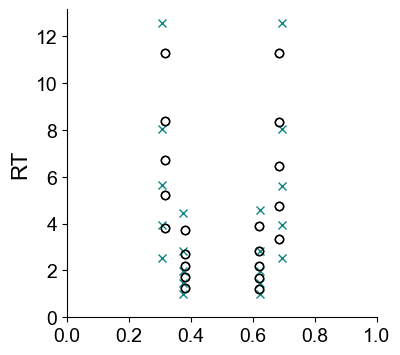

In [11]:
#data_dir = "/Users/wangjiashun/Desktop/Reserach on SAT/datasets/transformed/Lerche2017/sub"
sample_size = 38
figure, ax = plt.subplots(figsize=(4,4))
DDM_OUM_QP_plot(ax=ax, sample_size=sample_size, dataset="Lerche2017")

#ax.legend()

<Axes: xlabel='Probability of Response', ylabel='RT'>

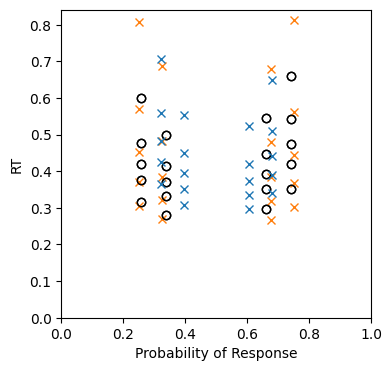

In [115]:
data_dir = "/Users/wangjiashun/Desktop/Reserach on SAT/datasets/Evans2021/Rae2014/dataBySubject/sub"
sample_size = 34
figure, ax = plt.subplots(figsize=(4,4))

DDM_OUM_QP_plot(ax=ax, data_dir=data_dir, sample_size=sample_size, dataset="Rae2014")

#ax.legend()

In [12]:
def DDM_OUM_QP_plot_EJ(freq,label, dataset="Wagenmakers2008", sample_size=16,  correct = 'Correct',corrects = [True, False],
                       cond = 'Cond', conds = ['Speed', 'Accuracy'],rt = 'Time',ax=None, legend = False):
    if ax is None:
        ax = plt.gca()
    
    quantiles = [.1, .3, .5, .7, .9]
    
    data_dir = "/Users/wangjiashun/Desktop/Research_on_SAT/datasets/transformed/Wagenmakers2008/dataByFreq/Freq"+str(freq)+"/sub"    

    ## behavioral data
    RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_RT_quantile(dataset=dataset, data_dir = data_dir,sample_size= sample_size, 
                                                                   correct = correct, corrects = corrects,
                                                                   cond = cond, conds = conds, rt = rt)
    #print(RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums)
    line_1, = ax.plot([nums[0]/(nums[0]+nums[2])]*5, RT_cor_s,"o", color = 'black', fillstyle = 'none')
    ax.plot([nums[1]/(nums[1]+nums[3])]*5, RT_cor_a,"o", color = 'black', fillstyle = 'none')
    ax.plot([nums[2]/(nums[0]+nums[2])]*5, RT_err_s,"o", color = 'black', fillstyle = 'none')
    ax.plot([nums[3]/(nums[1]+nums[3])]*5, RT_err_a,"o", color = 'black', fillstyle = 'none')

    ## data generated from DDM
    RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_RT_quantile_DDM(dataset=dataset, sample_size= sample_size, 
                                                                   correct = correct, corrects = corrects,
                                                                   cond = cond, conds = conds, rt = rt,freq = freq)
    #print(RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums)

    line_2, = ax.plot([nums[0]/(nums[0]+nums[2])]*5, RT_cor_s,"x", color = '#0E8585', fillstyle = 'none')
    ax.plot([nums[1]/(nums[1]+nums[3])]*5, RT_cor_a,"x", color = '#0E8585', fillstyle = 'none')
    ax.plot([nums[2]/(nums[0]+nums[2])]*5, RT_err_s,"x", color = '#0E8585', fillstyle = 'none')
    ax.plot([nums[3]/(nums[1]+nums[3])]*5, RT_err_a,"x", color = '#0E8585', fillstyle = 'none')

    ## data generated from OUM
    RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_RT_quantile_OUM2v2k2ter(dataset=dataset, sample_size= sample_size, 
                                                                   correct = correct, corrects = corrects,
                                                                   cond = cond, conds = conds, rt = rt,freq = freq)
    line_3, = ax.plot([nums[0]/(nums[0]+nums[2])]*5, RT_cor_s,"x", color = '#830783', fillstyle = 'none')
    ax.plot([nums[1]/(nums[1]+nums[3])]*5, RT_cor_a,"x", color = '#830783', fillstyle = 'none')
    ax.plot([nums[2]/(nums[0]+nums[2])]*5, RT_err_s,"x", color = '#830783', fillstyle = 'none')
    ax.plot([nums[3]/(nums[1]+nums[3])]*5, RT_err_a,"x", color = '#830783', fillstyle = 'none')
     
    # limits
    ax.set_xlim(0,1)
    ax.set_ylim(0,)
    #ax.set_xlabel("Probability of Response")
    ax.set_ylabel("RT",fontsize = 16)
    ax.set_title(label,fontsize = 20, weight='bold', fontname='Arial')
    
    ax.spines[['right', 'top']].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.legend().set_visible(False)
    if legend:
        ax.legend(handles = [line_1, line_2, line_3], labels =["Data", "DDM", "OUM"], loc='upper left', 
                  bbox_to_anchor=(1, 1),fontsize=16, frameon=False)
    return(ax)


In [11]:
Frequencies = [1,  2, 3,  4,  5,  6]
participants = [1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, 'Probability of Response')

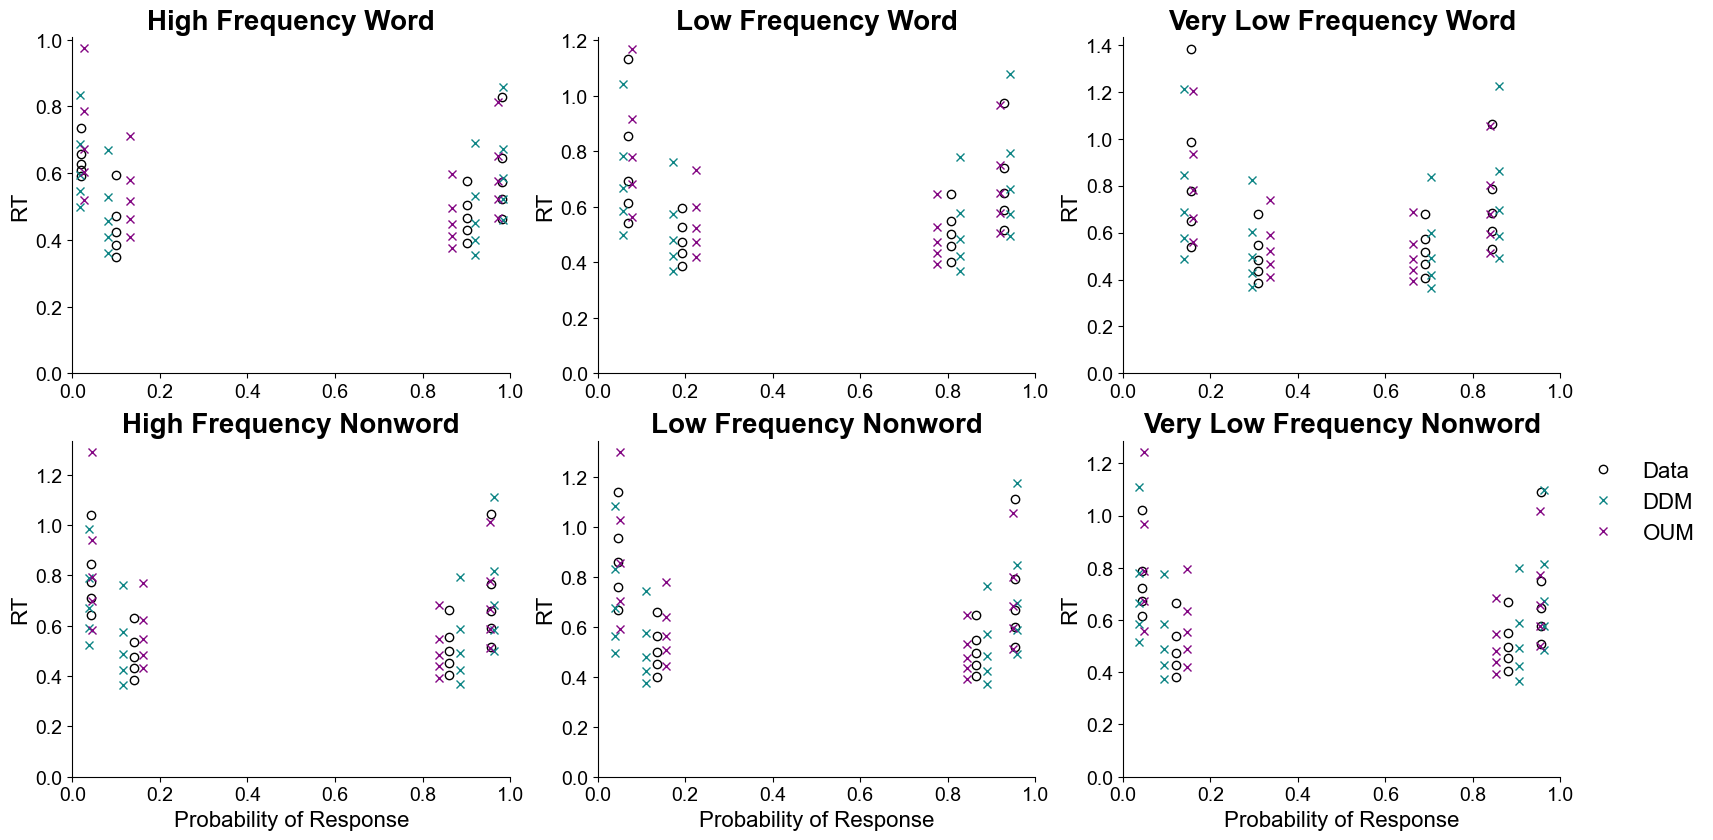

In [182]:
fig, ax = plt.subplots(2,3,figsize=[6.4*3, 4.8*2])

DDM_OUM_QP_plot_EJ(freq=1,label="High Frequency Word", ax = ax[0,0])
DDM_OUM_QP_plot_EJ(freq=2,label="Low Frequency Word", ax = ax[0,1])
DDM_OUM_QP_plot_EJ(freq=3,label="Very Low Frequency Word", ax = ax[0,2])
DDM_OUM_QP_plot_EJ(freq=4,label="High Frequency Nonword", ax = ax[1,0])
DDM_OUM_QP_plot_EJ(freq=5,label="Low Frequency Nonword", ax = ax[1,1])
DDM_OUM_QP_plot_EJ(freq=6,label="Very Low Frequency Nonword", ax = ax[1,2], legend = True)

ax[1,0].set_xlabel("Probability of Response",fontsize = 16)
ax[1,1].set_xlabel("Probability of Response",fontsize = 16)
ax[1,2].set_xlabel("Probability of Response",fontsize = 16)

#plt.legend(labels =["Data", "DDM", "OUM"], loc='upper left', bbox_to_anchor=(1, 1),fontsize=16, frameon=False)
#ax[1,2].set_xticks([])
#ax[1,2].axis('off')

(0.0, 1.0, 0.0, 1.0)

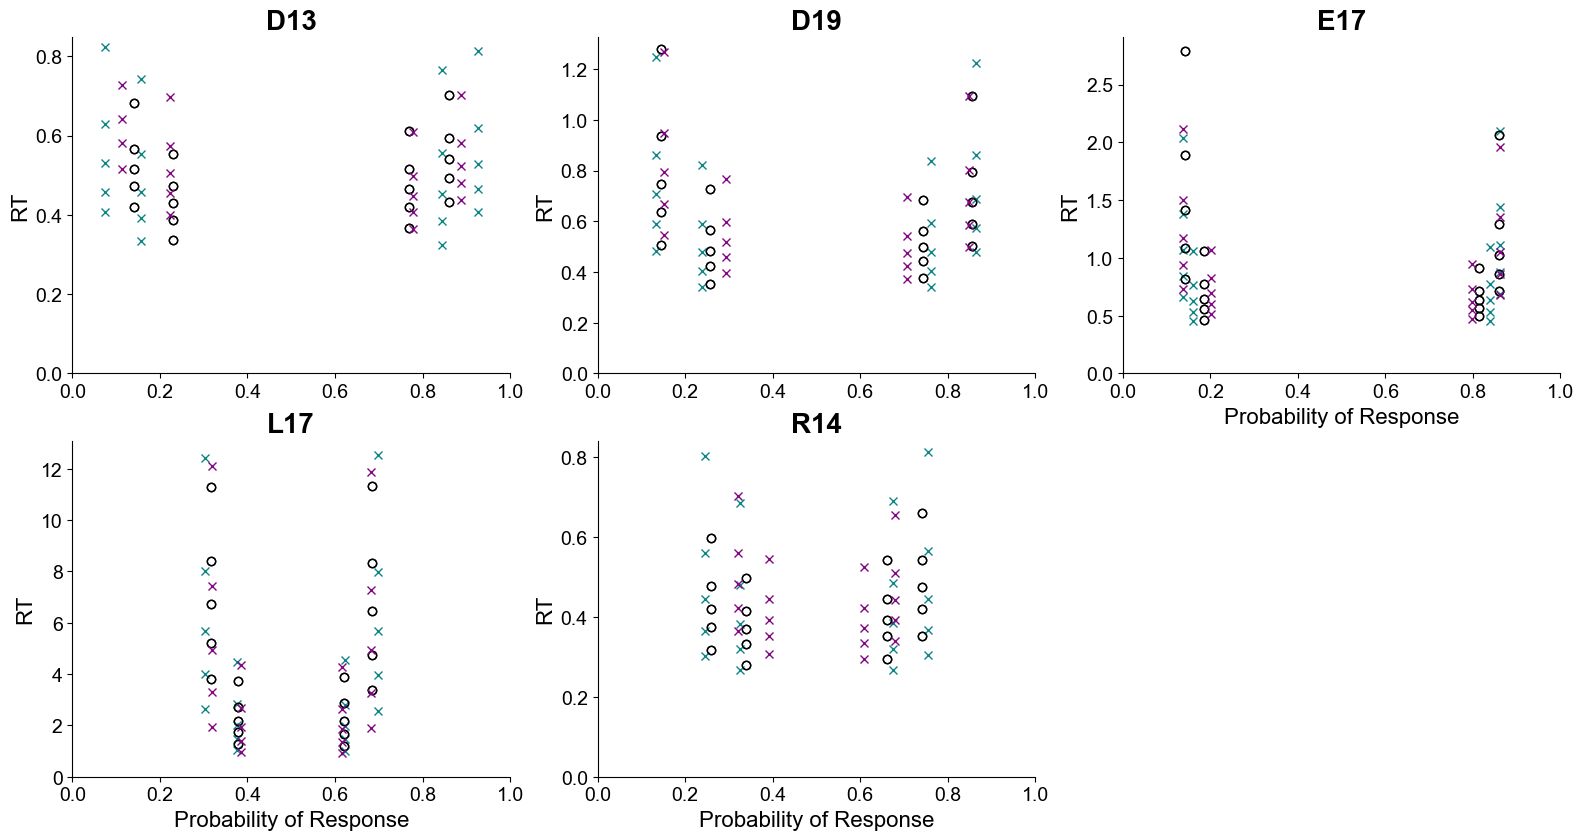

In [166]:
dataset_names = ['D13', 'D19', 'E17', 'L17', 'R14', 'W08']

fig, ax = plt.subplots(2,3,figsize=[6.4*3, 4.8*2])

DDM_OUM_QP_plot(ax=ax[0,0], sample_size=32, dataset="Dutilh2013")
DDM_OUM_QP_plot(ax=ax[0,1], sample_size=20, dataset="Dutilh2019")
DDM_OUM_QP_plot(ax=ax[0,2], sample_size=47, dataset="Evans2017")
DDM_OUM_QP_plot(ax=ax[1,0], sample_size=38, dataset="Lerche2017")
DDM_OUM_QP_plot(ax=ax[1,1], sample_size=34, dataset="Rae2014")


for i in range(3):
    ax[0,i].set_title(dataset_names[i],fontsize = 20, weight='bold', fontname='Arial')
    
for i in range(2):
    ax[1,i].set_title(dataset_names[i+3],fontsize = 20, weight='bold', fontname='Arial')

ax[1,0].set_xlabel("Probability of Response",fontsize = 16)
ax[1,1].set_xlabel("Probability of Response",fontsize = 16)
ax[0,2].set_xlabel("Probability of Response",fontsize = 16)

ax[1,2].set_xticks([])
ax[1,2].axis('off')
#l = plt.legend(handles[2:4], labels[2:4], bbox_to_anchor=(1.05, 2.1), loc=2, borderaxespad=0.,fontsize=16, frameon=False)
#axes[1,1].legend(labels =["Data", "DDM", "OUM"], loc='upper left', bbox_to_anchor=(0, 1),fontsize=16, frameon=False)

In [ ]:
axes[6].legend(labels =["Data", "DDM", "OUM"], loc='upper left', bbox_to_anchor=(1.1, 1),fontsize=10)


(0.0, 1.0, 0.0, 1.0)

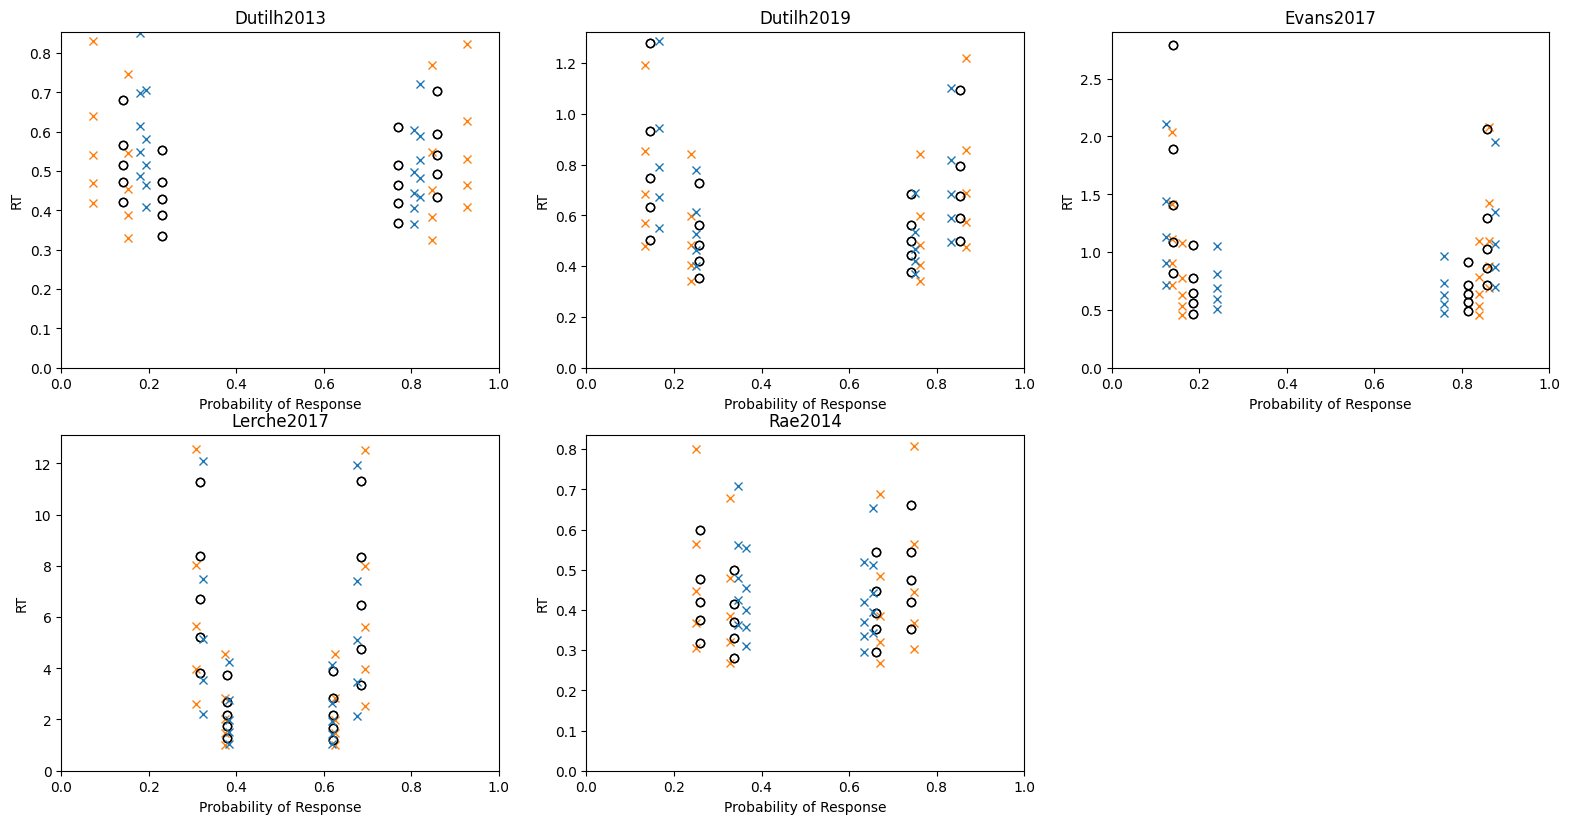

In [187]:
fig, ax = plt.subplots(2,3,figsize=[6.4*3, 4.8*2])

DDM_OUM2k2ter_QP_plot(ax=ax[0,0], sample_size=32, dataset="Dutilh2013")
DDM_OUM2k2ter_QP_plot(ax=ax[0,1], sample_size=20, dataset="Dutilh2019")
DDM_OUM2k2ter_QP_plot(ax=ax[0,2], sample_size=47, dataset="Evans2017")
DDM_OUM2k2ter_QP_plot(ax=ax[1,0], sample_size=38, dataset="Lerche2017")
DDM_OUM2k2ter_QP_plot(ax=ax[1,1], sample_size=34, dataset="Rae2014")


ax[1,2].set_xticks([])
ax[1,2].axis('off')

(0.0, 1.0, 0.0, 1.0)

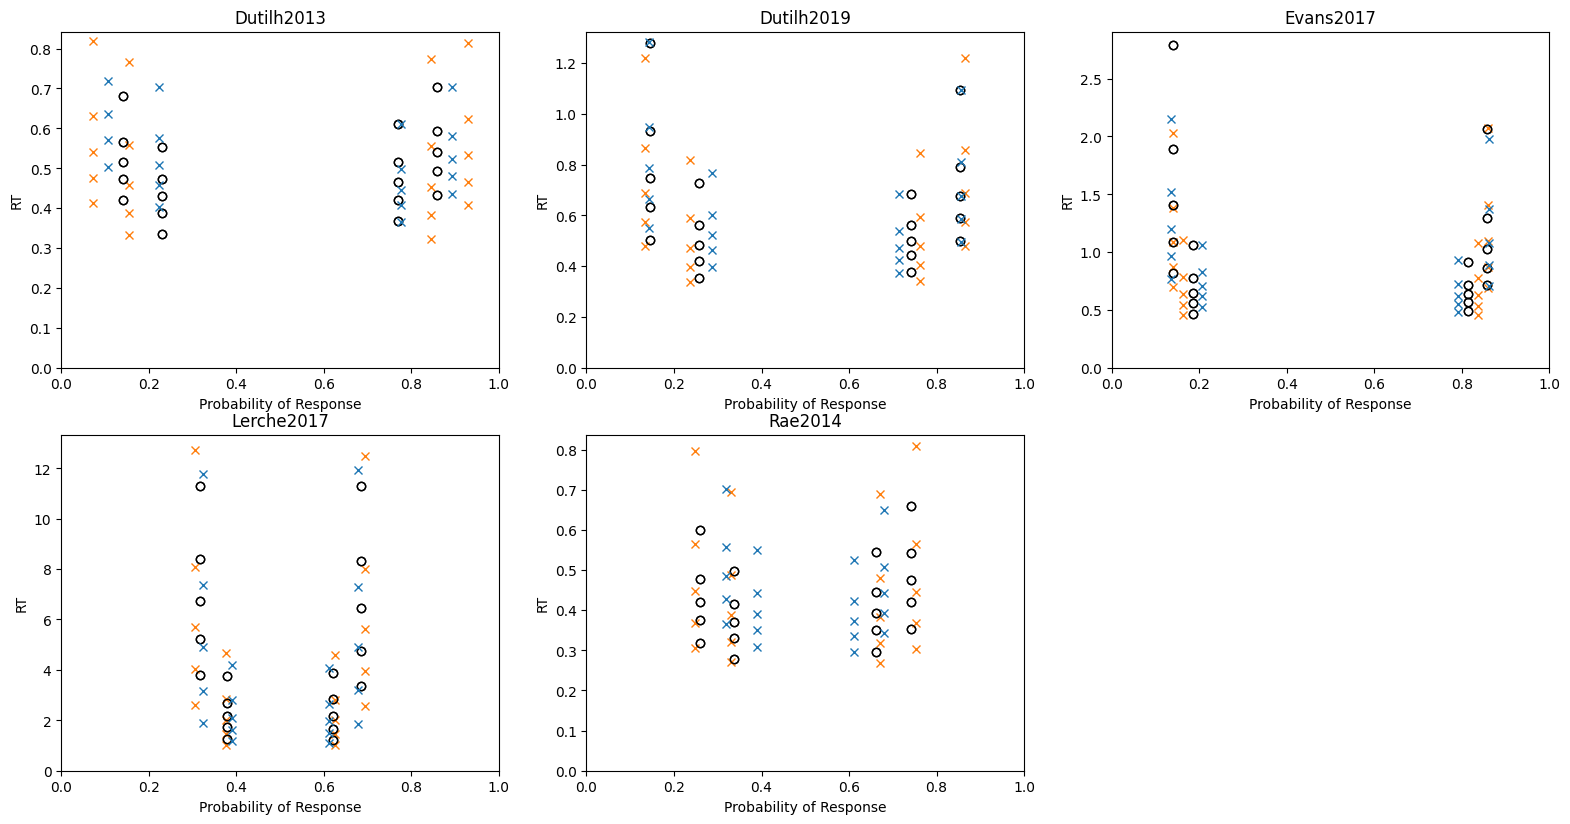

In [204]:
fig, ax = plt.subplots(2,3,figsize=[6.4*3, 4.8*2])

DDM_OUM2v2a2k2ter_QP_plot(ax=ax[0,0], sample_size=32, dataset="Dutilh2013")
DDM_OUM2v2a2k2ter_QP_plot(ax=ax[0,1], sample_size=20, dataset="Dutilh2019")
DDM_OUM2v2a2k2ter_QP_plot(ax=ax[0,2], sample_size=47, dataset="Evans2017")
DDM_OUM2v2a2k2ter_QP_plot(ax=ax[1,0], sample_size=38, dataset="Lerche2017")
DDM_OUM2v2a2k2ter_QP_plot(ax=ax[1,1], sample_size=34, dataset="Rae2014")


ax[1,2].set_xticks([])
ax[1,2].axis('off')

In [133]:
correct = 'Correct'
corrects = [True, False]
cond = 'Cond'
conds = ['Speed', 'Accuracy']
rt = 'Time'


In [81]:
dataset="Dutilh2013"
sample_size = 32

In [85]:
dataset="Dutilh2019"
sample_size = 20

In [88]:
dataset="Evans2017"
sample_size = 47

In [113]:
dataset = "Lerche2017"
sample_size = 38

In [94]:
dataset="Rae2014"
sample_size = 34

In [119]:
## data
data_dir = "/Users/wangjiashun/Desktop/Research_on_SAT/datasets/transformed/"+dataset+"/sub"
RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_all_RT_quantile(dataset=dataset, data_dir = data_dir,sample_size= sample_size, 
                                                               correct = correct, corrects = corrects,
                                                               cond = cond, conds = conds, rt = rt)
quantiles_data = pd.DataFrame({"cor_s":RT_cor_s[:,4]/RT_cor_s[:,2],"cor_a":RT_cor_a[:,4]/RT_cor_a[:,2], 
                               "err_s": RT_err_s[:,4]/RT_err_s[:,2],'err_a': RT_err_a[:,4]/RT_err_a[:,2]})

## data generated from DDM
params_DDM = pd.read_csv("Parameter Estimates/DDM2v2a2terresult"+dataset+".csv")#.drop(labels=3, axis=0)
RT_cor_s_DDM, RT_cor_a_DDM, RT_err_s_DDM, RT_err_a_DDM, nums_DDM = get_all_RT_quantile_DDM(dataset = dataset,sample_size= sample_size, 
                                                               correct = correct, corrects = corrects,
                                                               cond = cond, conds = conds, rt = rt)
quantiles_DDM = pd.DataFrame({"cor_s":RT_cor_s_DDM[:,4]/RT_cor_s[:,2],"cor_a":RT_cor_a_DDM[:,4]/RT_cor_a[:,2], "err_s": RT_err_s_DDM[:,4]/RT_err_s[:,2],'err_a': RT_err_a_DDM[:,4]/RT_err_a[:,2]})

## data generated from OUM
params_OUM = pd.read_csv("Parameter Estimates/OUM2v2k2terresult"+dataset+".csv")#.drop(labels=3, axis=0)
RT_cor_s_OUM, RT_cor_a_OUM, RT_err_s_OUM, RT_err_a_OUM, nums_OUM = get_all_RT_quantile_OUM2v2k2ter(dataset = dataset,sample_size= sample_size, 
                                                               correct = correct, corrects = corrects,
                                                               cond = cond, conds = conds, rt = rt)
quantiles_OUM = pd.DataFrame({"cor_s":RT_cor_s_OUM[:,4]/RT_cor_s[:,2],"cor_a":RT_cor_a_OUM[:,4]/RT_cor_a[:,2], "err_s": RT_err_s_OUM[:,4]/RT_err_s[:,2],'err_a': RT_err_a_OUM[:,4]/RT_err_a[:,2]})



In [96]:
quantiles_data.to_csv("Quantiles/quantiles_data_"+dataset)
quantiles_DDM.to_csv("Quantiles/quantiles_DDM_"  +dataset)
quantiles_OUM.to_csv("Quantiles/quantiles_OUM_"  +dataset)

In [97]:

dataset = "Wagenmakers2008"
sample_size = 16

In [107]:
quantiles_data,quantiles_DDM,quantiles_OUM =[],[],[]
for freq in Frequencies:
    data_dir = "/Users/wangjiashun/Desktop/Research_on_SAT/datasets/transformed/Wagenmakers2008/dataByFreq/Freq"+str(freq)+"/sub"    

    ## data generated from DDM
    RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_all_RT_quantile(dataset=dataset, data_dir = data_dir,sample_size= sample_size, 
                                                                   correct = correct, corrects = corrects,
                                                                   cond = cond, conds = conds, rt = rt)
    quantiles_data_df = pd.DataFrame({"cor_s":RT_cor_s[:,4]/RT_cor_s[:,2],"cor_a":RT_cor_a[:,4]/RT_cor_a[:,2], "err_s": RT_err_s[:,4]/RT_err_s[:,2],"err_a": RT_err_a[:,4]/RT_err_a[:,2]})

    ## data generated from DDM
    params_DDM = pd.read_csv("Parameter Estimates/DDM2v2a2terresult"+dataset+".csv")#.drop(labels=3, axis=0)
    RT_cor_s_DDM, RT_cor_a_DDM, RT_err_s_DDM, RT_err_a_DDM, nums_DDM = get_all_RT_quantile_DDM(dataset = dataset,sample_size= sample_size, 
                                                                   correct = correct, corrects = corrects,
                                                                    cond = cond, conds = conds, rt = rt)
    quantiles_DDM_df = pd.DataFrame({"cor_s":RT_cor_s_DDM[:,4]/RT_cor_s[:,2],"cor_a":RT_cor_a_DDM[:,4]/RT_cor_a[:,2], "err_s": RT_err_s_DDM[:,4]/RT_err_s[:,2],'err_a': RT_err_a_DDM[:,4]/RT_err_a[:,2]})                                                              

    ## data generated from OUM
    params_OUM = pd.read_csv("Parameter Estimates/OUM2v2k2terresult"+dataset+".csv")#.drop(labels=3, axis=0)
    RT_cor_s_OUM, RT_cor_a_OUM, RT_err_s_OUM, RT_err_a_OUM, nums_OUM = get_all_RT_quantile_OUM2v2k2ter(dataset = dataset,sample_size= sample_size, 
                                                                   correct = correct, corrects = corrects,
                                                                   cond = cond, conds = conds, rt = rt)
    quantiles_OUM_df = pd.DataFrame({"cor_s":RT_cor_s_OUM[:,4]/RT_cor_s[:,2],"cor_a":RT_cor_a_OUM[:,4]/RT_cor_a[:,2], "err_s": RT_err_s_OUM[:,4]/RT_err_s[:,2],'err_a': RT_err_a_OUM[:,4]/RT_err_a[:,2]})
    
    quantiles_data.append(quantiles_data_df)
    quantiles_DDM.append(quantiles_DDM_df)
    quantiles_OUM.append(quantiles_OUM_df)    

In [108]:
x = (quantiles_data[0]+quantiles_data[1]+quantiles_data[2]+quantiles_data[3]+quantiles_data[4]+quantiles_data[5])/6
y = (quantiles_DDM[0]+quantiles_DDM[1]+quantiles_DDM[2]+quantiles_DDM[3]+quantiles_DDM[4]+quantiles_DDM[5])/6
z = (quantiles_OUM[0]+quantiles_OUM[1]+quantiles_OUM[2]+quantiles_OUM[3]+quantiles_OUM[4]+quantiles_OUM[5])/6

x1 = x+y-y
y1 = y+x-x
z1 = z+x-x

x1.to_csv("Quantiles/quantiles_data_"+dataset)
y1.to_csv("Quantiles/quantiles_DDM_"  +dataset)
z1.to_csv("Quantiles/quantiles_OUM_"  +dataset)


In [53]:
df = pd.read_csv("/Users/wangjiashun/Desktop/Research_on_SAT/datasets/transformed/Lerche2017/sub1.csv")
df.mean()

/var/folders/5g/vqmn12yd48z6l6jf2s2yy62r0000gn/T/ipykernel_94032/982840416.py:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.mean()


Unnamed: 0    81.500000
Time           6.691640
Correct        0.652439
dtype: float64

In [114]:
## data
data_dir = "/Users/wangjiashun/Desktop/Research_on_SAT/datasets/transformed/"+dataset+"/sub"
RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_all_RT_quantile(dataset=dataset, data_dir = data_dir,sample_size= sample_size, 
                                                               correct = correct, corrects = corrects,
                                                               cond = cond, conds = conds, rt = rt)
quantiles_data = pd.DataFrame({"cor_s":RT_cor_s[:,4]/RT_cor_s[:,2],"cor_a":RT_cor_a[:,4]/RT_cor_a[:,2], 
                               "err_s": RT_err_s[:,4]/RT_err_s[:,2],'err_a': RT_err_a[:,4]/RT_err_a[:,2]})


In [175]:
data_dir = "/Users/wangjiashun/Desktop/Research_on_SAT/datasets/transformed/Lerche2017/sub"
path = os.path.join(data_dir+str(26)+".csv")
df = pd.read_csv(path, sep = ",")


(array([73.,  0.,  3.,  3.,  8.,  4.,  1.,  7.,  2.,  5.]),
 array([ 0.199 ,  3.0661,  5.9332,  8.8003, 11.6674, 14.5345, 17.4016,
        20.2687, 23.1358, 26.0029, 28.87  ]),
 <BarContainer object of 10 artists>)

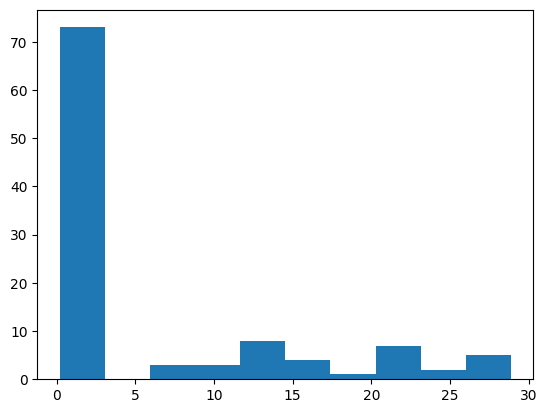

In [176]:
plt.hist(df.loc[df["Correct"]==1, "Time"])

In [120]:
RT_err_a[25]

array([0.2398, 0.2742, 0.33  , 0.3812, 8.7026])

In [12]:
def plot_09quantile_all_datasets_new(Condition, title, ax = None):
    if ax is None:
        ax = plt.gca()
    
    datasets = ["Dutilh 2013", "Dutilh 2019", "Evans 2017", "Lerche 2017", "Rae 2014", "Wagenmakers 2008"]

    all_dataset = pd.DataFrame()
    for dataset in datasets:
        quantiles_data = pd.read_csv("Quantiles/quantiles_data_"+ dataset.replace(" ", ""))
        quantiles_DDM  = pd.read_csv("Quantiles/quantiles_DDM_" + dataset.replace(" ", ""))
        quantiles_OUM  = pd.read_csv("Quantiles/quantiles_OUM_" + dataset.replace(" ", ""))
        if dataset=="Lerche 2017": # remove the err_a of 25 participant because the unusually larger 0.9 quantile
            #print(quantiles_data.loc[25,"err_a"])
            quantiles_data.loc[25,"err_a"] = quantiles_data["err_a"].mean()
            quantiles_DDM.loc[25,"err_a"] = quantiles_DDM["err_a"].mean()
            quantiles_OUM.loc[25,"err_a"] = quantiles_OUM["err_a"].mean()
            #print(quantiles_data.loc[25,"err_a"])
            
        single_dataset = pd.DataFrame({"Data":quantiles_data[Condition], "DDM":quantiles_DDM[Condition], "OUM":quantiles_OUM[Condition]})
        single_dataset["Dataset"] = dataset

        all_dataset = pd.concat((all_dataset,single_dataset))

    all_dataset_melted = pd.melt(all_dataset, value_vars=['Data', 'DDM','OUM'],
                                 var_name = "Model", value_name = "0.9 RT Quantile", id_vars = ["Dataset"])
    #fig, ax = plt.subplots()
    sns.lineplot(ax=ax, data=all_dataset_melted, x="Dataset", y="0.9 RT Quantile", hue="Model",#err_kws={'capsize':5}, 
                 legend = False,err_style="band",errorbar = "ci",palette = ["black","#0E8585", "#7262ac"])#, hue_order=["Speed","Accuracy"])
    sns.scatterplot(data = all_dataset_melted.groupby(["Dataset","Model"]).aggregate("mean"),legend = False,
                x="Dataset", y="0.9 RT Quantile", hue="Model", marker="o", hue_order = ['Data', 'DDM','OUM'], 
                    palette = ["black","#0E8585", "#7262ac"], ax=ax)
    #ax.set_ylim(0, 2.5)
    ax.set_title(title)
    ax.set_xlabel("")
    ax.set_xticks(range(6), ['D13', 'D19', 'E17', 'L17', 'R14', 'W08'], font = "Arial", size = 10)

    ax.set_ylabel("0.9 RT Quantiles", font = "Arial", size = 10)
    ax.spines[['right', 'top']].set_visible(False)


    return ax

Text(0.5, 1.0, 'Incorrect Choices (Accuracy)')

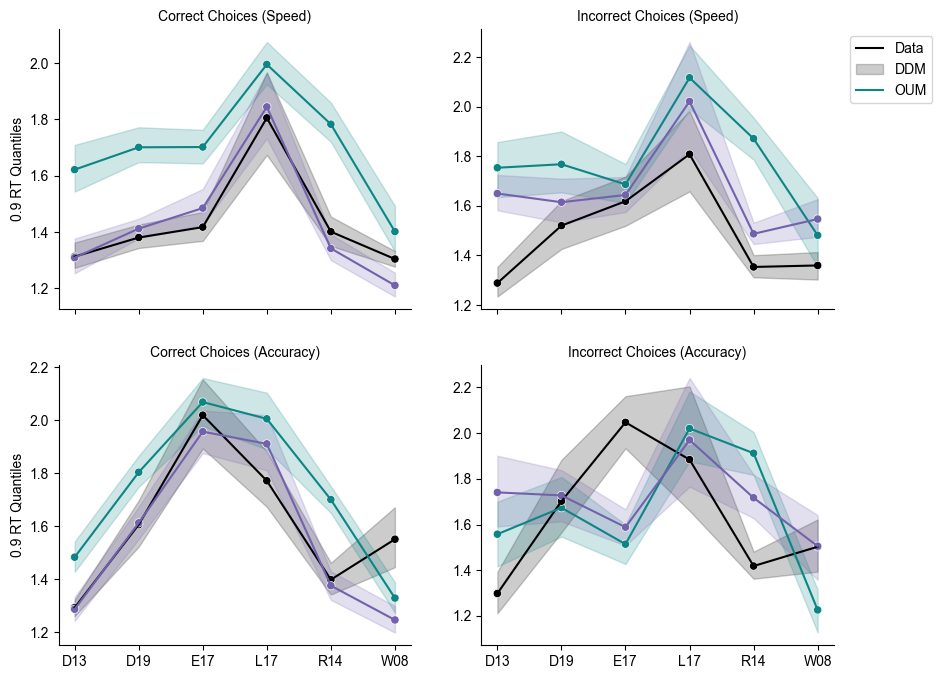

In [196]:
%run SAT_help_functions.ipynb
fig, axes = plt.subplots(2,2,figsize=(10, 8))
plot_09quantile_all_datasets_new(Condition = "cor_s", title = "Correct Choices (Speed)", ax=axes[0,0])
plot_09quantile_all_datasets_new(Condition = "err_s", title = "Incorrect Choices (Speed)", ax=axes[0,1])
plot_09quantile_all_datasets_new(Condition = "cor_a", title = "Correct Choices (Accuracy)", ax=axes[1,0])
plot_09quantile_all_datasets_new(Condition = "err_a", title = "Incorrect Choices (Accuracy)", ax=axes[1,1])

axes[0,0].set_xticks(range(6), [""]*6)
axes[0,1].set_xticks(range(6), [""]*6)

axes[0,1].set_ylabel("")
axes[1,1].set_ylabel("")

axes[0,1].legend(["Data", "DDM", "OUM"], loc = "upper right",bbox_to_anchor=(1.3, 1))

axes[0,0].set_title("Correct Choices (Speed)", font = "Arial", size = 10)
axes[0,1].set_title("Incorrect Choices (Speed)", font = "Arial", size = 10)
axes[1,0].set_title("Correct Choices (Accuracy)", font = "Arial", size = 10)
axes[1,1].set_title("Incorrect Choices (Accuracy)", font = "Arial", size = 10)



Text(0.5, 1.0, 'Incorrect Choices (Accuracy)')

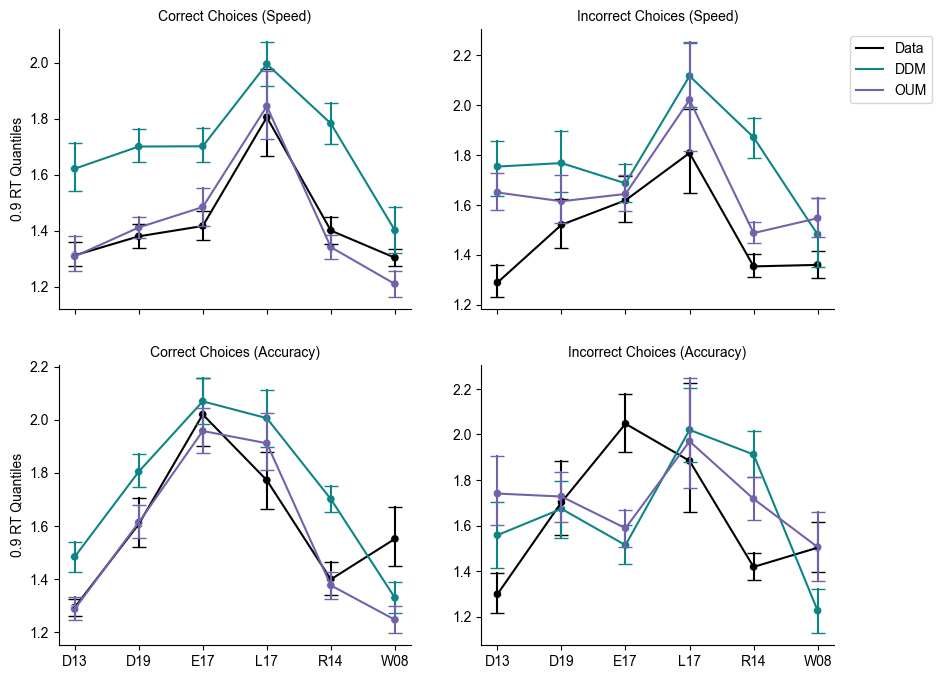

In [71]:
%run SAT_help_functions.ipynb
fig, axes = plt.subplots(2,2,figsize=(10, 8))
plot_09quantile_all_datasets_new(Condition = "cor_s", title = "Correct Choices (Speed)", ax=axes[0,0])
plot_09quantile_all_datasets_new(Condition = "err_s", title = "Incorrect Choices (Speed)", ax=axes[0,1])
plot_09quantile_all_datasets_new(Condition = "cor_a", title = "Correct Choices (Accuracy)", ax=axes[1,0])
plot_09quantile_all_datasets_new(Condition = "err_a", title = "Incorrect Choices (Accuracy)", ax=axes[1,1])

axes[0,0].set_xticks(range(6), [""]*6)
axes[0,1].set_xticks(range(6), [""]*6)

axes[0,1].set_ylabel("")
axes[1,1].set_ylabel("")

axes[0,1].legend(["Data", "DDM", "OUM"], loc = "upper right",bbox_to_anchor=(1.3, 1))

axes[0,0].set_title("Correct Choices (Speed)", font = "Arial", size = 10)
axes[0,1].set_title("Incorrect Choices (Speed)", font = "Arial", size = 10)
axes[1,0].set_title("Correct Choices (Accuracy)", font = "Arial", size = 10)
axes[1,1].set_title("Incorrect Choices (Accuracy)", font = "Arial", size = 10)



## 0.1 quantile

In [134]:
dataset="Dutilh2013"
sample_size = 32

In [137]:
dataset="Dutilh2019"
sample_size = 20

In [140]:
dataset="Evans2017"
sample_size = 47

In [143]:
dataset = "Lerche2017"
sample_size = 38

In [146]:
dataset="Rae2014"
sample_size = 34

In [147]:
## data
data_dir = "/Users/wangjiashun/Desktop/Research_on_SAT/datasets/transformed/"+dataset+"/sub"
RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_all_RT_quantile(dataset=dataset, data_dir = data_dir,sample_size= sample_size, 
                                                               correct = correct, corrects = corrects,
                                                               cond = cond, conds = conds, rt = rt)
quantiles_data = pd.DataFrame({"cor_s":RT_cor_s[:,0]/RT_cor_s[:,2],"cor_a":RT_cor_a[:,0]/RT_cor_a[:,2], 
                               "err_s": RT_err_s[:,0]/RT_err_s[:,2],'err_a': RT_err_a[:,0]/RT_err_a[:,2]})

## data generated from DDM
params_DDM = pd.read_csv("Parameter Estimates/DDM2v2a2terresult"+dataset+".csv")#.drop(labels=3, axis=0)
RT_cor_s_DDM, RT_cor_a_DDM, RT_err_s_DDM, RT_err_a_DDM, nums_DDM = get_all_RT_quantile_DDM(dataset = dataset,sample_size= sample_size, 
                                                               correct = correct, corrects = corrects,
                                                               cond = cond, conds = conds, rt = rt)
quantiles_DDM = pd.DataFrame({"cor_s":RT_cor_s_DDM[:,0]/RT_cor_s[:,2],"cor_a":RT_cor_a_DDM[:,0]/RT_cor_a[:,2], "err_s": RT_err_s_DDM[:,0]/RT_err_s[:,2],'err_a': RT_err_a_DDM[:,0]/RT_err_a[:,2]})

## data generated from OUM
params_OUM = pd.read_csv("Parameter Estimates/OUM2v2k2terresult"+dataset+".csv")#.drop(labels=3, axis=0)
RT_cor_s_OUM, RT_cor_a_OUM, RT_err_s_OUM, RT_err_a_OUM, nums_OUM = get_all_RT_quantile_OUM2v2k2ter(dataset = dataset,sample_size= sample_size, 
                                                               correct = correct, corrects = corrects,
                                                               cond = cond, conds = conds, rt = rt)
quantiles_OUM = pd.DataFrame({"cor_s":RT_cor_s_OUM[:,0]/RT_cor_s[:,2],"cor_a":RT_cor_a_OUM[:,0]/RT_cor_a[:,2], "err_s": RT_err_s_OUM[:,0]/RT_err_s[:,2],'err_a': RT_err_a_OUM[:,0]/RT_err_a[:,2]})



In [148]:
quantiles_data.to_csv("Quantiles/01quantiles_data_"+dataset)
quantiles_DDM.to_csv("Quantiles/01quantiles_DDM_"  +dataset)
quantiles_OUM.to_csv("Quantiles/01quantiles_OUM_"  +dataset)

In [149]:

dataset = "Wagenmakers2008"
sample_size = 16

In [150]:
quantiles_data,quantiles_DDM,quantiles_OUM =[],[],[]
for freq in Frequencies:
    data_dir = "/Users/wangjiashun/Desktop/Research_on_SAT/datasets/transformed/Wagenmakers2008/dataByFreq/Freq"+str(freq)+"/sub"    

    ## data generated from DDM
    RT_cor_s, RT_cor_a, RT_err_s, RT_err_a, nums = get_all_RT_quantile(dataset=dataset, data_dir = data_dir,sample_size= sample_size, 
                                                                   correct = correct, corrects = corrects,
                                                                   cond = cond, conds = conds, rt = rt)
    quantiles_data_df = pd.DataFrame({"cor_s":RT_cor_s[:,0]/RT_cor_s[:,2],"cor_a":RT_cor_a[:,0]/RT_cor_a[:,2], "err_s": RT_err_s[:,0]/RT_err_s[:,2],"err_a": RT_err_a[:,0]/RT_err_a[:,2]})

    ## data generated from DDM
    params_DDM = pd.read_csv("Parameter Estimates/DDM2v2a2terresult"+dataset+".csv")#.drop(labels=3, axis=0)
    RT_cor_s_DDM, RT_cor_a_DDM, RT_err_s_DDM, RT_err_a_DDM, nums_DDM = get_all_RT_quantile_DDM(dataset = dataset,sample_size= sample_size, 
                                                                   correct = correct, corrects = corrects,
                                                                    cond = cond, conds = conds, rt = rt)
    quantiles_DDM_df = pd.DataFrame({"cor_s":RT_cor_s_DDM[:,0]/RT_cor_s[:,2],"cor_a":RT_cor_a_DDM[:,0]/RT_cor_a[:,2], "err_s": RT_err_s_DDM[:,0]/RT_err_s[:,2],'err_a': RT_err_a_DDM[:,0]/RT_err_a[:,2]})                                                              

    ## data generated from OUM
    params_OUM = pd.read_csv("Parameter Estimates/OUM2v2k2terresult"+dataset+".csv")#.drop(labels=3, axis=0)
    RT_cor_s_OUM, RT_cor_a_OUM, RT_err_s_OUM, RT_err_a_OUM, nums_OUM = get_all_RT_quantile_OUM2v2k2ter(dataset = dataset,sample_size= sample_size, 
                                                                   correct = correct, corrects = corrects,
                                                                   cond = cond, conds = conds, rt = rt)
    quantiles_OUM_df = pd.DataFrame({"cor_s":RT_cor_s_OUM[:,0]/RT_cor_s[:,2],"cor_a":RT_cor_a_OUM[:,0]/RT_cor_a[:,2], "err_s": RT_err_s_OUM[:,0]/RT_err_s[:,2],'err_a': RT_err_a_OUM[:,0]/RT_err_a[:,2]})
    
    quantiles_data.append(quantiles_data_df)
    quantiles_DDM.append(quantiles_DDM_df)
    quantiles_OUM.append(quantiles_OUM_df)    

In [151]:
x = (quantiles_data[0]+quantiles_data[1]+quantiles_data[2]+quantiles_data[3]+quantiles_data[4]+quantiles_data[5])/6
y = (quantiles_DDM[0]+quantiles_DDM[1]+quantiles_DDM[2]+quantiles_DDM[3]+quantiles_DDM[4]+quantiles_DDM[5])/6
z = (quantiles_OUM[0]+quantiles_OUM[1]+quantiles_OUM[2]+quantiles_OUM[3]+quantiles_OUM[4]+quantiles_OUM[5])/6

x1 = x+y-y
y1 = y+x-x
z1 = z+x-x

x1.to_csv("Quantiles/01quantiles_data_"+dataset)
y1.to_csv("Quantiles/01quantiles_DDM_"  +dataset)
z1.to_csv("Quantiles/01quantiles_OUM_"  +dataset)


In [13]:
def plot_01quantile_all_datasets_new(Condition, title, ax = None):
    if ax is None:
        ax = plt.gca()
    
    datasets = ["Dutilh 2013", "Dutilh 2019", "Evans 2017", "Lerche 2017", "Rae 2014", "Wagenmakers 2008"]

    all_dataset = pd.DataFrame()
    for dataset in datasets:
        quantiles_data = pd.read_csv("Quantiles/01quantiles_data_"+ dataset.replace(" ", ""))
        quantiles_DDM  = pd.read_csv("Quantiles/01quantiles_DDM_" + dataset.replace(" ", ""))
        quantiles_OUM  = pd.read_csv("Quantiles/01quantiles_OUM_" + dataset.replace(" ", ""))
        single_dataset = pd.DataFrame({"Data":quantiles_data[Condition], "DDM":quantiles_DDM[Condition], "OUM":quantiles_OUM[Condition]})
        single_dataset["Dataset"] = dataset

        all_dataset = pd.concat((all_dataset,single_dataset))

    all_dataset_melted = pd.melt(all_dataset, value_vars=['Data', 'DDM','OUM'],
                                 var_name = "Model", value_name = "0.1 RT Quantile", id_vars = ["Dataset"])
    #fig, ax = plt.subplots()
    sns.lineplot(ax=ax, data=all_dataset_melted, x="Dataset", y="0.1 RT Quantile", hue="Model",  #legend = False,
                 err_style="band",errorbar = "ci",palette = ["black","#0E8585", "#7262ac"])#, hue_order=["Speed","Accuracy"])
    sns.scatterplot(data = all_dataset_melted.groupby(["Dataset","Model"]).aggregate("mean"),legend = False,
                x="Dataset", y="0.1 RT Quantile", hue="Model", marker="o", hue_order = ['Data', 'DDM','OUM'], 
                    palette = ["black","#0E8585", "#7262ac"], ax=ax)
    #ax.set_ylim(0, 2.5)
    ax.set_title(title, font = "Arial", size = 16, weight='bold')
    ax.set_xlabel("")
    ax.set_xticks(range(6), ['D13', 'D19', 'E17', 'L17', 'R14', 'W08'], font = "Arial", size = 10)



    return ax

def plot_09quantile_all_datasets_new(Condition, title, ax = None):
    if ax is None:
        ax = plt.gca()
    
    datasets = ["Dutilh 2013", "Dutilh 2019", "Evans 2017", "Lerche 2017", "Rae 2014", "Wagenmakers 2008"]

    all_dataset = pd.DataFrame()
    for dataset in datasets:
        quantiles_data = pd.read_csv("Quantiles/quantiles_data_"+ dataset.replace(" ", ""))
        quantiles_DDM  = pd.read_csv("Quantiles/quantiles_DDM_" + dataset.replace(" ", ""))
        quantiles_OUM  = pd.read_csv("Quantiles/quantiles_OUM_" + dataset.replace(" ", ""))
        if dataset=="Lerche 2017": # remove the err_a of 25 participant because the unusually larger 0.9 quantile
            #print(quantiles_data.loc[25,"err_a"])
            quantiles_data.loc[25,"err_a"] = quantiles_data["err_a"].mean()
            quantiles_DDM.loc[25,"err_a"] = quantiles_DDM["err_a"].mean()
            quantiles_OUM.loc[25,"err_a"] = quantiles_OUM["err_a"].mean()
            #print(quantiles_data.loc[25,"err_a"])
            
        single_dataset = pd.DataFrame({"Data":quantiles_data[Condition], "DDM":quantiles_DDM[Condition], "OUM":quantiles_OUM[Condition]})
        single_dataset["Dataset"] = dataset

        all_dataset = pd.concat((all_dataset,single_dataset))

    all_dataset_melted = pd.melt(all_dataset, value_vars=['Data', 'DDM','OUM'],
                                 var_name = "Model", value_name = "0.9 RT Quantile", id_vars = ["Dataset"])
    #fig, ax = plt.subplots()
    sns.lineplot(ax=ax, data=all_dataset_melted, x="Dataset", y="0.9 RT Quantile", hue="Model",
                 legend = False,err_style="band",errorbar = "ci",palette = ["black","#0E8585", "#7262ac"])#, hue_order=["Speed","Accuracy"])
    sns.scatterplot(data = all_dataset_melted.groupby(["Dataset","Model"]).aggregate("mean"),legend = False,
                x="Dataset", y="0.9 RT Quantile", hue="Model", marker="o", hue_order = ['Data', 'DDM','OUM'], 
                    palette = ["black","#0E8585", "#7262ac"], ax=ax)
    #ax.set_ylim(0, 2.5)
    ax.set_title(title, font = "Arial", size = 16, weight='bold')
    ax.set_xlabel("")
    ax.set_xticks(range(6), ['D13', 'D19', 'E17', 'L17', 'R14', 'W08'], font = "Arial", size = 10)

    ax.set_ylabel("0.9 RT Quantiles", font = "Arial", size = 10)
    ax.spines[['right', 'top']].set_visible(False)


    return ax

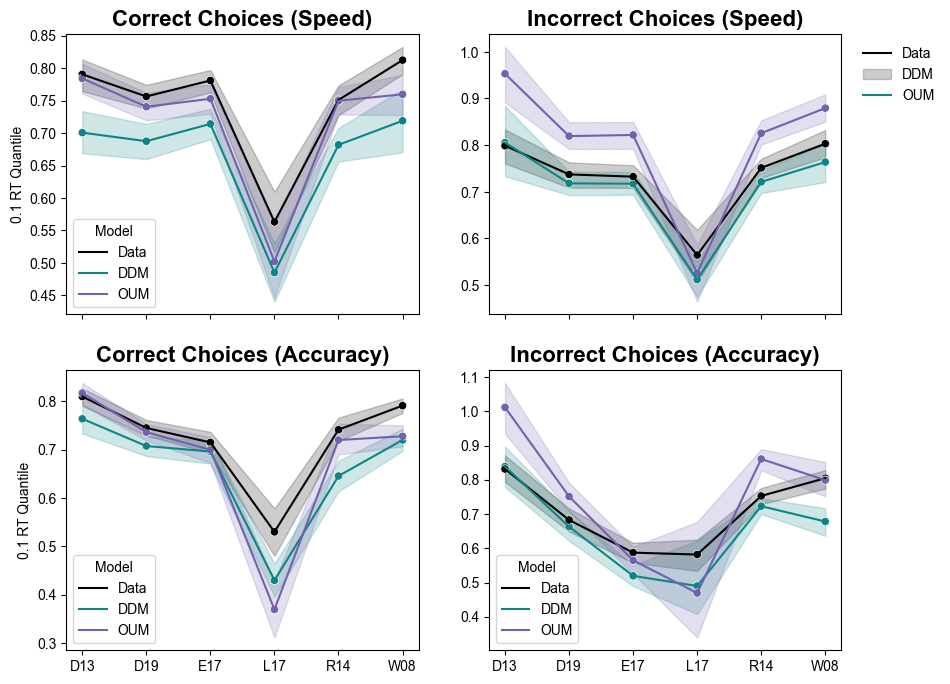

In [223]:
%run SAT_help_functions.ipynb
fig, axes = plt.subplots(2,2,figsize=(10, 8))
plot_01quantile_all_datasets_new(Condition = "cor_s", title = "Correct Choices (Speed)", ax=axes[0,0])
plot_01quantile_all_datasets_new(Condition = "err_s", title = "Incorrect Choices (Speed)", ax=axes[0,1])
plot_01quantile_all_datasets_new(Condition = "cor_a", title = "Correct Choices (Accuracy)", ax=axes[1,0])
plot_01quantile_all_datasets_new(Condition = "err_a", title = "Incorrect Choices (Accuracy)", ax=axes[1,1])

axes[0,0].set_xticks(range(6), [""]*6)
axes[0,1].set_xticks(range(6), [""]*6)

axes[0,1].set_ylabel("")
axes[1,1].set_ylabel("")


axes[0,1].legend(["Data", "DDM", "OUM"], loc = "upper right",bbox_to_anchor=(1.3, 1), frameon=False)



#axes[0,0].set_xticks("")
#axes[1,1].set_xticks("")
#axes[0,1].set_yticks("")
#axes[1,1].set_yticks("")

['Data', 'DDM', 'OUM']


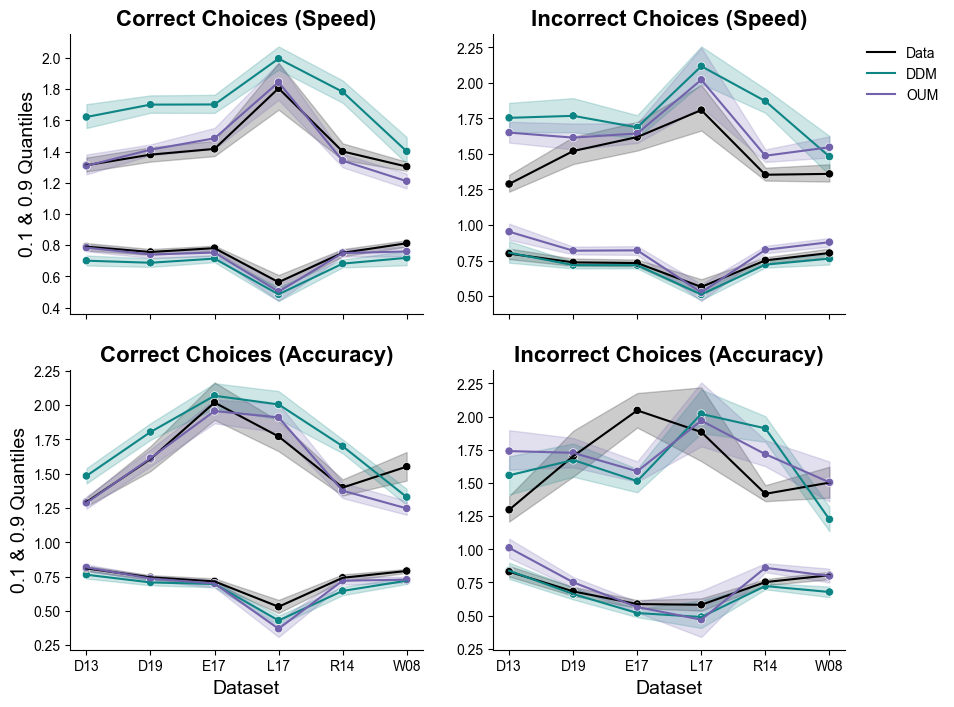

In [14]:
%run SAT_help_functions.ipynb
fig, axes = plt.subplots(2,2,figsize=(10, 8))

plot_09quantile_all_datasets_new(Condition = "cor_s", title = "Correct Choices (Speed)", ax=axes[0,0])
plot_09quantile_all_datasets_new(Condition = "err_s", title = "Incorrect Choices (Speed)", ax=axes[0,1])
plot_09quantile_all_datasets_new(Condition = "cor_a", title = "Correct Choices (Accuracy)", ax=axes[1,0])
plot_09quantile_all_datasets_new(Condition = "err_a", title = "Incorrect Choices (Accuracy)", ax=axes[1,1])


plot_01quantile_all_datasets_new(Condition = "cor_s", title = "Correct Choices (Speed)", ax=axes[0,0])
plot_01quantile_all_datasets_new(Condition = "err_s", title = "Incorrect Choices (Speed)", ax=axes[0,1])
plot_01quantile_all_datasets_new(Condition = "cor_a", title = "Correct Choices (Accuracy)", ax=axes[1,0])
plot_01quantile_all_datasets_new(Condition = "err_a", title = "Incorrect Choices (Accuracy)", ax=axes[1,1])

axes[0,0].set_xticks(range(6), [""]*6)
axes[0,1].set_xticks(range(6), [""]*6)


axes[0,0].set_ylabel("0.1 & 0.9 Quantiles", font = "Arial", fontsize = 14)
axes[1,0].set_ylabel("0.1 & 0.9 Quantiles", font = "Arial", fontsize = 14)

axes[0,1].set_ylabel("")
axes[1,1].set_ylabel("")

axes[1,0].set_xlabel("Dataset", fontsize = 14)
axes[1,1].set_xlabel("Dataset", fontsize = 14)

h, l = axes[0,1].get_legend_handles_labels()

print(l)

axes[0,0].get_legend().remove()
axes[0,1].get_legend().remove()
axes[1,0].get_legend().remove()
axes[1,1].get_legend().remove()


#axes[0,1].legend(["Data", "95% CI for Data", "DDM", "95% CI for Data","OUM", "95% CI for Data"], 
#                 loc = "upper right",bbox_to_anchor=(1.5, 1), frameon=False)
axes[0,1].legend(h, l,loc = "upper right",bbox_to_anchor=(1.3, 1), frameon=False)
#axes[0,0].set_xticks("")
#axes[1,1].set_xticks("")
#axes[0,1].set_yticks("")
#axes[1,1].set_yticks("")

In [16]:
datasets = ['Dutilh2013', 'Dutilh2019', 'Evans2017', 'Lerche2017', 'Rae2014', 'Wagenmakers2008']
dataset_names = ['D13', 'D19', 'E17', 'L17', 'R14', 'W08']

results = pd.DataFrame()

for i in range(6):
    result = pd.DataFrame()
    #print(i)
    
    df_OUM_k = pd.read_csv('Parameter Estimates/OUM2v2a2k2terresult'+datasets[i]+'.csv')[["Self-excitation Speed","Self-excitation Accuracy"]]
    df_DDM_c = pd.read_csv('Parameter Estimates/DDM2v2a2c2terresult'+datasets[i]+'.csv')[["Collapse Speed","Collapse Accuracy"]]

    if datasets[i] =='Wagenmakers2008':
        df_OUM_k = pd.read_csv('Parameter Estimates/OUM2v2a2k2terresult'+datasets[i]+'.csv')[["Self-excitation Speed","Self-excitation Accuracy","Participant"]]
        df_DDM_c = pd.read_csv('Parameter Estimates/DDM2v2a2c2terresult'+datasets[i]+'.csv')[["Collapse Speed","Collapse Accuracy","Participant"]]

        df_OUM_k = df_OUM_k.groupby(by="Participant").mean()
        df_DDM_c = df_DDM_c.groupby(by="Participant").mean()
        
    df_OUM_k_dif = df_OUM_k["Self-excitation Speed"] - df_OUM_k["Self-excitation Accuracy"]
    df_DDM_c_dif = df_DDM_c["Collapse Speed"] - df_DDM_c["Collapse Accuracy"]
        
    #df_SAT_melted = transform_df_OUM_dif(df_SAT)
    #df_SAT_melted["Dataset"] = dataset_names[i]
    #result = pd.concat((df_OUM_k,df_DDM_c), axis = 1)
    
    result["Difference in Self-excitation"] = df_OUM_k_dif
    result["Difference in Collapse Rate"] = df_DDM_c_dif
    
    result["Dataset"] = dataset_names[i]
    
    results = pd.concat((results,result))


Text(0, 0.5, 'Difference in Collapse Rate (LCBM)')

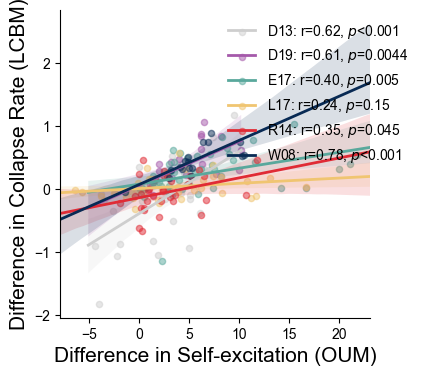

In [23]:
fig, ax = plt.subplots(1,1, figsize=(4,4))

color_codes = ["#cecece", "#a559aa", "#59a89c", "#f0c571", "#e02b35", "#082a54"]
for i in range(6):
               
    line = sns.regplot(x="Difference in Self-excitation",y="Difference in Collapse Rate", color=color_codes[i],
                    data=results[results["Dataset"]==dataset_names[i]], truncate=False, label=dataset_names[i],
                    scatter=True, scatter_kws={"s": 20, "alpha":0.5}, ax=ax,
                      line_kws={'lw': 2, 'label': 'Regression for ' + dataset_names[i]}) #"edgecolor":"black", 

ax.spines[['right', 'top']].set_visible(False)



handles, labels = ax.get_legend_handles_labels()
n = 6
labels_new = ["D13: r=0.62, $p$<0.001","D19: r=0.61, $p$=0.0044","E17: r=0.40, $p$=0.005","L17: r=0.24, $p$=0.15","R14: r=0.35, $p$=0.045","W08: r=0.78, $p$<0.001"]

ax.legend(handles=[(h1, h2) for h1, h2 in zip(handles[slice(0,12,2)], handles[slice(1,12,2)])],
         labels=labels_new,fontsize=10,loc='upper left', bbox_to_anchor=(0.5, 1), frameon=False)

ax.set_xlabel("Difference in Self-excitation (OUM)", fontsize = 15)
ax.set_ylabel("Difference in Collapse Rate (LCBM)", fontsize = 15)

In [14]:
def SAT_plot(DDM_params, OUM_params,ax=None):
    if ax is None:
        ax = plt.gca()
    T_dur = 1.5
    
    ### DDM
    model = Model(name='Simple model',
                  drift=DriftConstant(drift=DDM_params[0]),
                  noise=NoiseConstant(noise=1),
                  bound=BoundConstant(B=DDM_params[1]),
                  overlay=OverlayNonDecision(nondectime=DDM_params[2]),
                  dx=.001, dt=.001, T_dur=T_dur)
    sol = model.solve()
    samp = sol.resample(10000)
    samps = samp.to_pandas_dataframe(drop_undecided = True, choice_column_name='correct')

    evidence = model.simulate_trial(seed=1)
    t = np.arange(len(evidence))/1000
    t_kde = np.arange(0,T_dur*1000)/1000
    #print(samps)

    c_prop = sum(samps['correct']==1)/len(samps['correct'])
    i_prop = sum(samps['correct']==0)/len(samps['correct'])


    kde_c = stats.gaussian_kde(samps[samps['correct']==1]['RT'])(t_kde)*c_prop
    kde_i = stats.gaussian_kde(samps[samps['correct']==0]['RT'])(t_kde)*i_prop
    line1 = ax.plot(t_kde,kde_c/2+1, color = '#0E8585', label = "DDM",linewidth=2)
    RT_quantiles = np.quantile(samps[samps['correct']==1]['RT'], [0.1,0.3,0.5,0.7,0.9], axis=0)
    ax.scatter(RT_quantiles, stats.gaussian_kde(samps[samps['correct']==1]['RT'])(RT_quantiles)*c_prop/2+1,
               edgecolor="#0E8585", facecolor = "#0E8585",marker = "x")

    ### OUM
    model = Model(name='Simple model',
                  drift=DriftLinear(drift=OUM_params[0],x = OUM_params[2], t = 0),
                  noise=NoiseConstant(noise=1),
                  bound=BoundConstant(B=OUM_params[1]),
                  overlay=OverlayNonDecision(nondectime=OUM_params[3]),
                  dx=.001, dt=.001, T_dur=T_dur)
    sol = model.solve()
    samp = sol.resample(10000)
    samps = samp.to_pandas_dataframe(drop_undecided = True, choice_column_name='correct')

    evidence = model.simulate_trial(seed=1)
    t = np.arange(len(evidence))/1000
    t_kde = np.arange(0,T_dur*1000)/1000
    #print(samps)

    c_prop = sum(samps['correct']==1)/len(samps['correct'])
    i_prop = sum(samps['correct']==0)/len(samps['correct'])

    kde_c = stats.gaussian_kde(samps[samps['correct']==1]['RT'])(t_kde)*c_prop
    kde_i = stats.gaussian_kde(samps[samps['correct']==0]['RT'])(t_kde)*i_prop
    line2 = ax.plot(t_kde,kde_c/2+1, color = '#7262ac', label = "OUM",linewidth=2)
    RT_quantiles = np.quantile(samps[samps['correct']==1]['RT'], [0.1,0.3,0.5,0.7,0.9], axis=0)
    ax.scatter(RT_quantiles, stats.gaussian_kde(samps[samps['correct']==1]['RT'])(RT_quantiles)*c_prop/2+1,
               edgecolor="#7262ac", facecolor = "#7262ac",marker = "x")

    #ax.arrow(x=0.8, y=1.2, dx=-0.06, dy=0, color = 'black',head_width=0.03, head_length=0.03)

    # plot limit
    #ax.axis('off')
    ax.tick_params(left = False, bottom = False, labelleft = False, labelbottom = False)
    ax.legend(frameon=False)
    #ax.set_xlabel("RT")
    #ax.set_ylabel("Density")

    ax.spines[['right', 'top']].set_visible(False)


    return(ax)


/var/folders/5g/vqmn12yd48z6l6jf2s2yy62r0000gn/T/ipykernel_22061/3140514595.py:30: UserWarning: You passed a edgecolor/edgecolors ('#0E8585') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(RT_quantiles, stats.gaussian_kde(samps[samps['correct']==1]['RT'])(RT_quantiles)*c_prop/2+1,
/var/folders/5g/vqmn12yd48z6l6jf2s2yy62r0000gn/T/ipykernel_22061/3140514595.py:56: UserWarning: You passed a edgecolor/edgecolors ('#7262ac') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(RT_quantiles, stats.gaussian_kde(samps[samps['correct']==1]['RT'])(RT_quantiles)*c_prop/2+1,


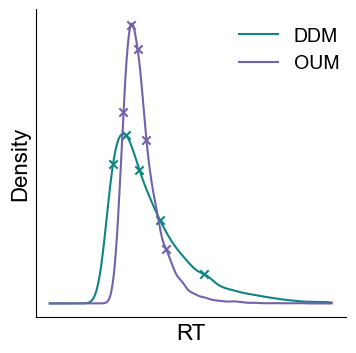

/var/folders/5g/vqmn12yd48z6l6jf2s2yy62r0000gn/T/ipykernel_28081/899413721.py:30: UserWarning: You passed a edgecolor/edgecolors ('#0E8585') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(RT_quantiles, stats.gaussian_kde(samps[samps['correct']==1]['RT'])(RT_quantiles)*c_prop/2+1,
/var/folders/5g/vqmn12yd48z6l6jf2s2yy62r0000gn/T/ipykernel_28081/899413721.py:56: UserWarning: You passed a edgecolor/edgecolors ('#7262ac') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(RT_quantiles, stats.gaussian_kde(samps[samps['correct']==1]['RT'])(RT_quantiles)*c_prop/2+1,


['Data', 'DDM', 'OUM']


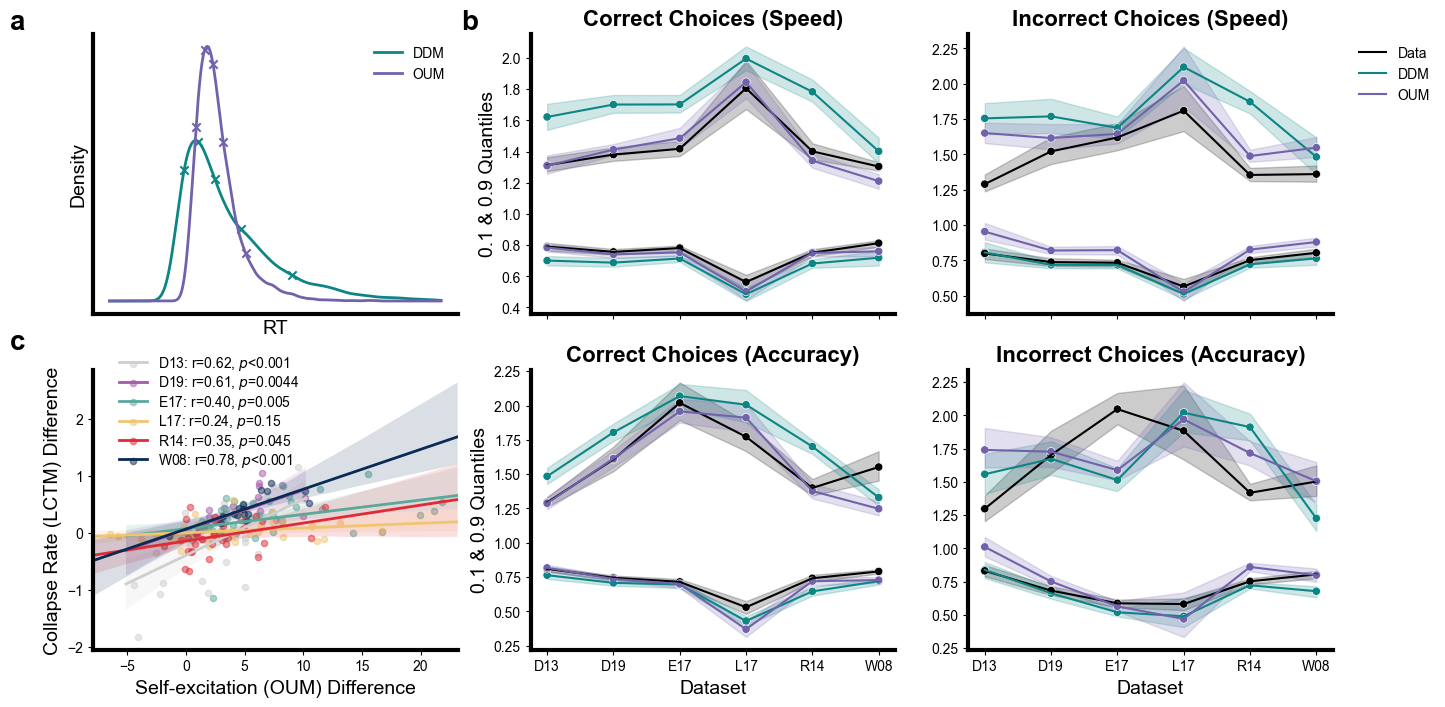

In [19]:
%run SAT_help_functions.ipynb
fig, axes = plt.subplots(2,3,figsize=(16, 8))
## a
DDM_params = [1.99, 0.68, 0.24]
OUM_params = [1.98, 3.12,9.60, 0.20]
SAT_plot(DDM_params, OUM_params, ax = axes[0,0])

axes[0,0].set_xlabel("RT", fontsize = 14)
axes[0,0].set_ylabel("Density", fontsize = 14)

## b
color_codes = ["#cecece", "#a559aa", "#59a89c", "#f0c571", "#e02b35", "#082a54"]
for i in range(6):
               
    line = sns.regplot(x="Difference in Self-excitation",y="Difference in Collapse Rate", color=color_codes[i],
                    data=results[results["Dataset"]==dataset_names[i]], truncate=False, label=dataset_names[i],
                    scatter=True, scatter_kws={"s": 20, "alpha":0.5}, ax=axes[1,0],
                      line_kws={'lw': 2, 'label': 'Regression for ' + dataset_names[i]}) #"edgecolor":"black", 

axes[1,0].spines[['right', 'top']].set_visible(False)

#axes[1,0].tick_params(left = False, bottom = False, labelleft = False, labelbottom = False)



handles, labels = axes[1,0].get_legend_handles_labels()
n = 6
labels_new = ["D13: r=0.62, $p$<0.001","D19: r=0.61, $p$=0.0044","E17: r=0.40, $p$=0.005","L17: r=0.24, $p$=0.15","R14: r=0.35, $p$=0.045","W08: r=0.78, $p$<0.001"]

axes[1,0].legend(handles=[(h1, h2) for h1, h2 in zip(handles[slice(0,12,2)], handles[slice(1,12,2)])],
         labels=labels_new,fontsize=10,loc='upper right', bbox_to_anchor=(0.6, 1.1), frameon=False,labelspacing = 0.1)

axes[1,0].set_xlabel("Self-excitation (OUM) Difference", fontsize = 14)
axes[1,0].set_ylabel("Collapse Rate (LCTM) Difference", fontsize = 14)
#axes[1,0].set_ylim(-2,4)

## c

plot_09quantile_all_datasets_new(Condition = "cor_s", title = "Correct Choices (Speed)", ax=axes[0,1])
plot_09quantile_all_datasets_new(Condition = "err_s", title = "Incorrect Choices (Speed)", ax=axes[0,2])
plot_09quantile_all_datasets_new(Condition = "cor_a", title = "Correct Choices (Accuracy)", ax=axes[1,1])
plot_09quantile_all_datasets_new(Condition = "err_a", title = "Incorrect Choices (Accuracy)", ax=axes[1,2])


plot_01quantile_all_datasets_new(Condition = "cor_s", title = "Correct Choices (Speed)", ax=axes[0,1])
plot_01quantile_all_datasets_new(Condition = "err_s", title = "Incorrect Choices (Speed)", ax=axes[0,2])
plot_01quantile_all_datasets_new(Condition = "cor_a", title = "Correct Choices (Accuracy)", ax=axes[1,1])
plot_01quantile_all_datasets_new(Condition = "err_a", title = "Incorrect Choices (Accuracy)", ax=axes[1,2])

axes[0,1].set_xticks(range(6), [""]*6)
axes[0,2].set_xticks(range(6), [""]*6)


axes[0,1].set_ylabel("0.1 & 0.9 Quantiles", font = "Arial", fontsize = 14)
axes[1,1].set_ylabel("0.1 & 0.9 Quantiles", font = "Arial", fontsize = 14)

axes[0,2].set_ylabel("")
axes[1,2].set_ylabel("")

axes[1,1].set_xlabel("Dataset", fontsize = 14)
axes[1,2].set_xlabel("Dataset", fontsize = 14)

h, l = axes[0,2].get_legend_handles_labels()

print(l)

axes[0,1].get_legend().remove()
axes[0,2].get_legend().remove()
axes[1,1].get_legend().remove()
axes[1,2].get_legend().remove()


subplots_list = [(0,0),(0,1),(0,2),(1,0),(1,1),(1,2)]
for i in range(6):
    axes[subplots_list[i]].spines[['left', 'bottom']].set_linewidth(3)

#axes[0,1].legend(["Data", "95% CI for Data", "DDM", "95% CI for Data","OUM", "95% CI for Data"], 
#                 loc = "upper right",bbox_to_anchor=(1.5, 1), frameon=False)
axes[0,2].legend(h, l,loc = "upper right",bbox_to_anchor=(1.3, 1), frameon=False)
#axes[0,0].set_xticks("")
#axes[1,1].set_xticks("")
#axes[0,1].set_yticks("")
#axes[1,1].set_yticks("")

##label 

plt.text(x=-14.7,y=4.9, s="a", fontsize = 20, weight='bold')
plt.text(x=-14.7,y=2.5, s="c", fontsize = 20, weight='bold')
plt.text(x=-7.9,y=4.9, s="b", fontsize = 20, weight='bold')

plt.rcParams['pdf.fonttype']=42
plt.rcParams['ps.fonttype']=42

plt.savefig("/Users/wangjiashun/Desktop/Research_on_SAT/Draft/Figures/fig4.pdf",bbox_inches = 'tight')


In [28]:
h, l = axes[0,1].get_legend_handles_labels()

In [214]:
axes[0,1].get_legend()

In [202]:
def plot_09quantile_all_datasets_new(Condition, title, ax = None):
    if ax is None:
        ax = plt.gca()
    
    datasets = ["Dutilh 2013", "Dutilh 2019", "Evans 2017", "Lerche 2017", "Rae 2014", "Wagenmakers 2008"]

    all_dataset = pd.DataFrame()
    for dataset in datasets:
        quantiles_data = pd.read_csv("Quantiles/quantiles_data_"+ dataset.replace(" ", ""))
        quantiles_DDM  = pd.read_csv("Quantiles/quantiles_DDM_" + dataset.replace(" ", ""))
        quantiles_OUM  = pd.read_csv("Quantiles/quantiles_OUM_" + dataset.replace(" ", ""))
        if dataset=="Lerche 2017": # remove the err_a of 25 participant because the unusually larger 0.9 quantile
            #print(quantiles_data.loc[25,"err_a"])
            quantiles_data.loc[25,"err_a"] = quantiles_data["err_a"].mean()
            quantiles_DDM.loc[25,"err_a"] = quantiles_DDM["err_a"].mean()
            quantiles_OUM.loc[25,"err_a"] = quantiles_OUM["err_a"].mean()
            #print(quantiles_data.loc[25,"err_a"])
            
        single_dataset = pd.DataFrame({"Data":quantiles_data[Condition], "DDM":quantiles_DDM[Condition], "OUM":quantiles_OUM[Condition]})
        single_dataset["Dataset"] = dataset

        all_dataset = pd.concat((all_dataset,single_dataset))

    all_dataset_melted = pd.melt(all_dataset, value_vars=['Data', 'DDM','OUM'],
                                 var_name = "Model", value_name = "0.9 RT Quantile", id_vars = ["Dataset"])
    #sns.lineplot(ax=ax, data=all_dataset_melted, x="Dataset", y="0.9 RT Quantile", hue="Model", 
    #             legend = False,err_style="bars",errorbar = "ci",palette = ["black","#0E8585", "#7262ac"])#, hue_order=["Speed","Accuracy"])
    #sns.scatterplot(data = all_dataset_melted.groupby(["Dataset","Model"]).aggregate("mean"),legend = False,
    #            x="Dataset", y="0.9 RT Quantile", hue="Model", marker="o", hue_order = ['Data', 'DDM','OUM'], 
    #                palette = ["black","#0E8585", "#7262ac"], ax=ax)
    
    sns.boxplot(ax=ax, data=all_dataset_melted, x="Dataset", y="0.9 RT Quantile", hue="Model",showfliers = False,
                  palette = ["black","#0E8585", "#7262ac"],legend = False)
    #sns.stripplot(ax = ax, data=all_dataset_melted, x="Dataset", y="0.9 RT Quantile", hue="Model",
    #              palette=["white"]*6, alpha=.3,edgecolor="black",linewidth=1,size = 3)

    #ax.set_ylim(0, 2.5)
    ax.set_title(title)
    ax.set_xlabel("")
    ax.set_xticks(range(6), ['D13', 'D19', 'E17', 'L17', 'R14', 'W08'], font = "Arial", size = 10)

    ax.set_ylabel("0.9 RT Quantiles", font = "Arial", size = 10)
    ax.spines[['right', 'top']].set_visible(False)


    return ax

<Axes: title={'center': 'Correct Choices (Speed)'}, ylabel='0.9 RT Quantiles'>

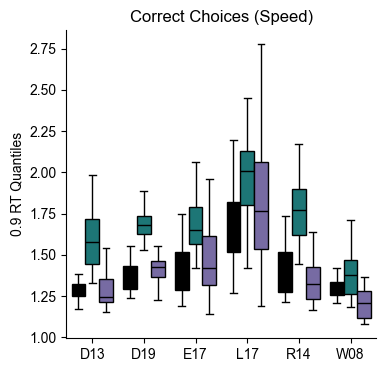

In [84]:
fig, axes = plt.subplots(1,1,figsize=(4, 4))

plot_09quantile_all_datasets_new(Condition = "cor_s", title = "Correct Choices (Speed)", ax=axes)

Text(0.5, 1.0, 'Incorrect Choices (Accuracy)')

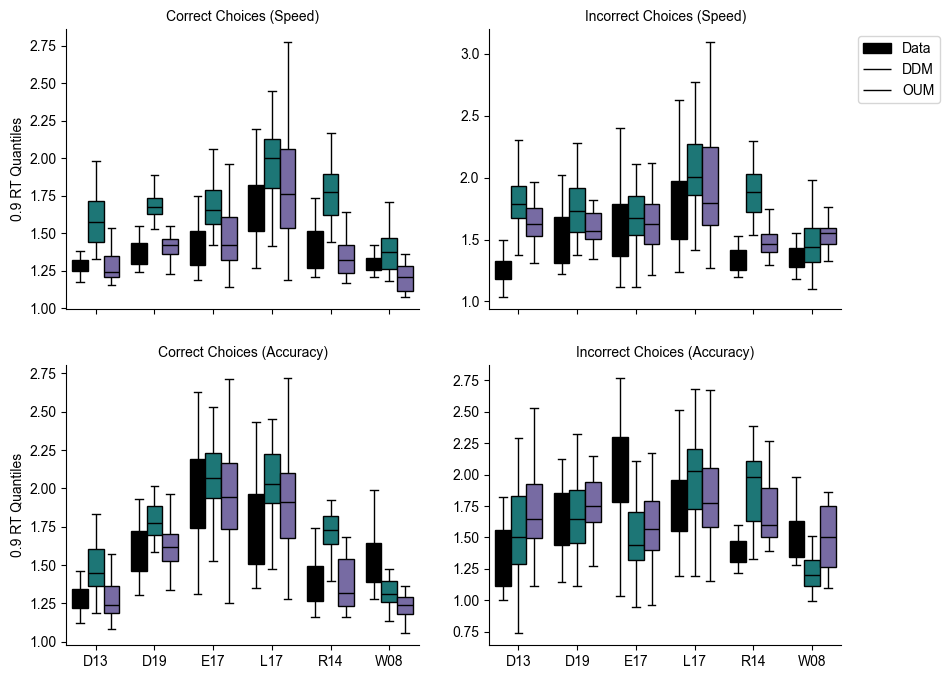

In [85]:
fig, axes = plt.subplots(2,2,figsize=(10, 8))
plot_09quantile_all_datasets_new(Condition = "cor_s", title = "Correct Choices (Speed)", ax=axes[0,0])
plot_09quantile_all_datasets_new(Condition = "err_s", title = "Incorrect Choices (Speed)", ax=axes[0,1])
plot_09quantile_all_datasets_new(Condition = "cor_a", title = "Correct Choices (Accuracy)", ax=axes[1,0])
plot_09quantile_all_datasets_new(Condition = "err_a", title = "Incorrect Choices (Accuracy)", ax=axes[1,1])

axes[0,0].set_xticks(range(6), [""]*6)
axes[0,1].set_xticks(range(6), [""]*6)

axes[0,1].set_ylabel("")
axes[1,1].set_ylabel("")

axes[0,1].legend(["Data", "DDM", "OUM"], loc = "upper right",bbox_to_anchor=(1.3, 1))

axes[0,0].set_title("Correct Choices (Speed)", font = "Arial", size = 10)
axes[0,1].set_title("Incorrect Choices (Speed)", font = "Arial", size = 10)
axes[1,0].set_title("Correct Choices (Accuracy)", font = "Arial", size = 10)
axes[1,1].set_title("Incorrect Choices (Accuracy)", font = "Arial", size = 10)

